In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

In [3]:
# Removing negative values from model output after rescaling.
def neg_to_zero(arr):
  arr = np.squeeze(arr)
  return np.where(arr<0, 0, arr)

# To rescale data using the scaling factors used in standardizing.
def rescaler(arr):
  return np.squeeze(arr)*scaling_factors.at['Rainfall', 'Standard Dev.']+scaling_factors.at['Rainfall', 'Mean']

# Standard function to load and save model and its predicted output (rescaled) in a dictionary.
def model_load_and_predict(model = 'SRCNN'):
  model = tf.keras.models.load_model('../MODEL_RUNS/EXP001_'+model+'/EXP001_'+model+'_best_model.h5', compile = False)
  output = neg_to_zero(rescaler(model.predict(testing_data['lr_inputs'])[:,:,:,0]))
  return model, output

In [4]:
testing_data = np.load('../DATA/Testing_2016-2021_Scaled.npz',  allow_pickle=True)

# Loading the scaling factors to destandardize the output values.
scaling_factors = pd.DataFrame(testing_data['scaling_factors'],columns = ['Mean', 'Standard Dev.'], \
                               index = ['Rainfall', 'Topography', 'Net Wind'])

inputs = rescaler(testing_data['lr_inputs'][:,:,:,0]) # Low-resolution 1.00 degree RF inputs.
groundtruths = rescaler(testing_data['hr_outputs'][:,:,:,0]) # High-resolution 0.25 degree RF ground-truth data, provided by IMD.

# Loading mask file
mask_025 = np.load('../DATA/masks.npz')['mask_025']
mask_100 = np.load('../DATA/masks.npz')['mask_100']

models, outputs = {}, {}
# Bicubic interpolated output achieved using Climate Data Operators on the original low-resolution netCDF file (using 'remapbic' command).
outputs['BICUBIC'] = neg_to_zero(xr.open_dataset('../DATA/RF_INTERPBIC_025_2016_2021.nc').rf.values)
for x in ['SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  models[x], outputs[x] = model_load_and_predict(model = x)

# Loading other variables (for plotting purposes): Latitude, Longitude & Testing Dates ranges
other = np.load('../DATA/other_variables.npz')

69/69 [==============================] - 0s 3ms/step


## **Plotting code**

In [5]:
# Selecting the timestep cases for qualitative analysis
# Criterion: More than 120 mm rainfall over 50% or more of the domain
percent = []
for _ in range(groundtruths.shape[0]):
  unique, counts = np.unique(groundtruths[_] > 120, return_counts=True)
  if counts.shape[0] == 1:
    percent.append(0)
  else:
    percent.append(counts[1]*100/(counts[0]+counts[1]))

percent = np.asarray(percent)
indexes = list(np.where(percent > 0.50)[0])
indexes

[588, 589, 590, 1314, 1315, 1316, 1317, 1318, 2030, 2083]

<ipython-input-6-f1a9ed09c473>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


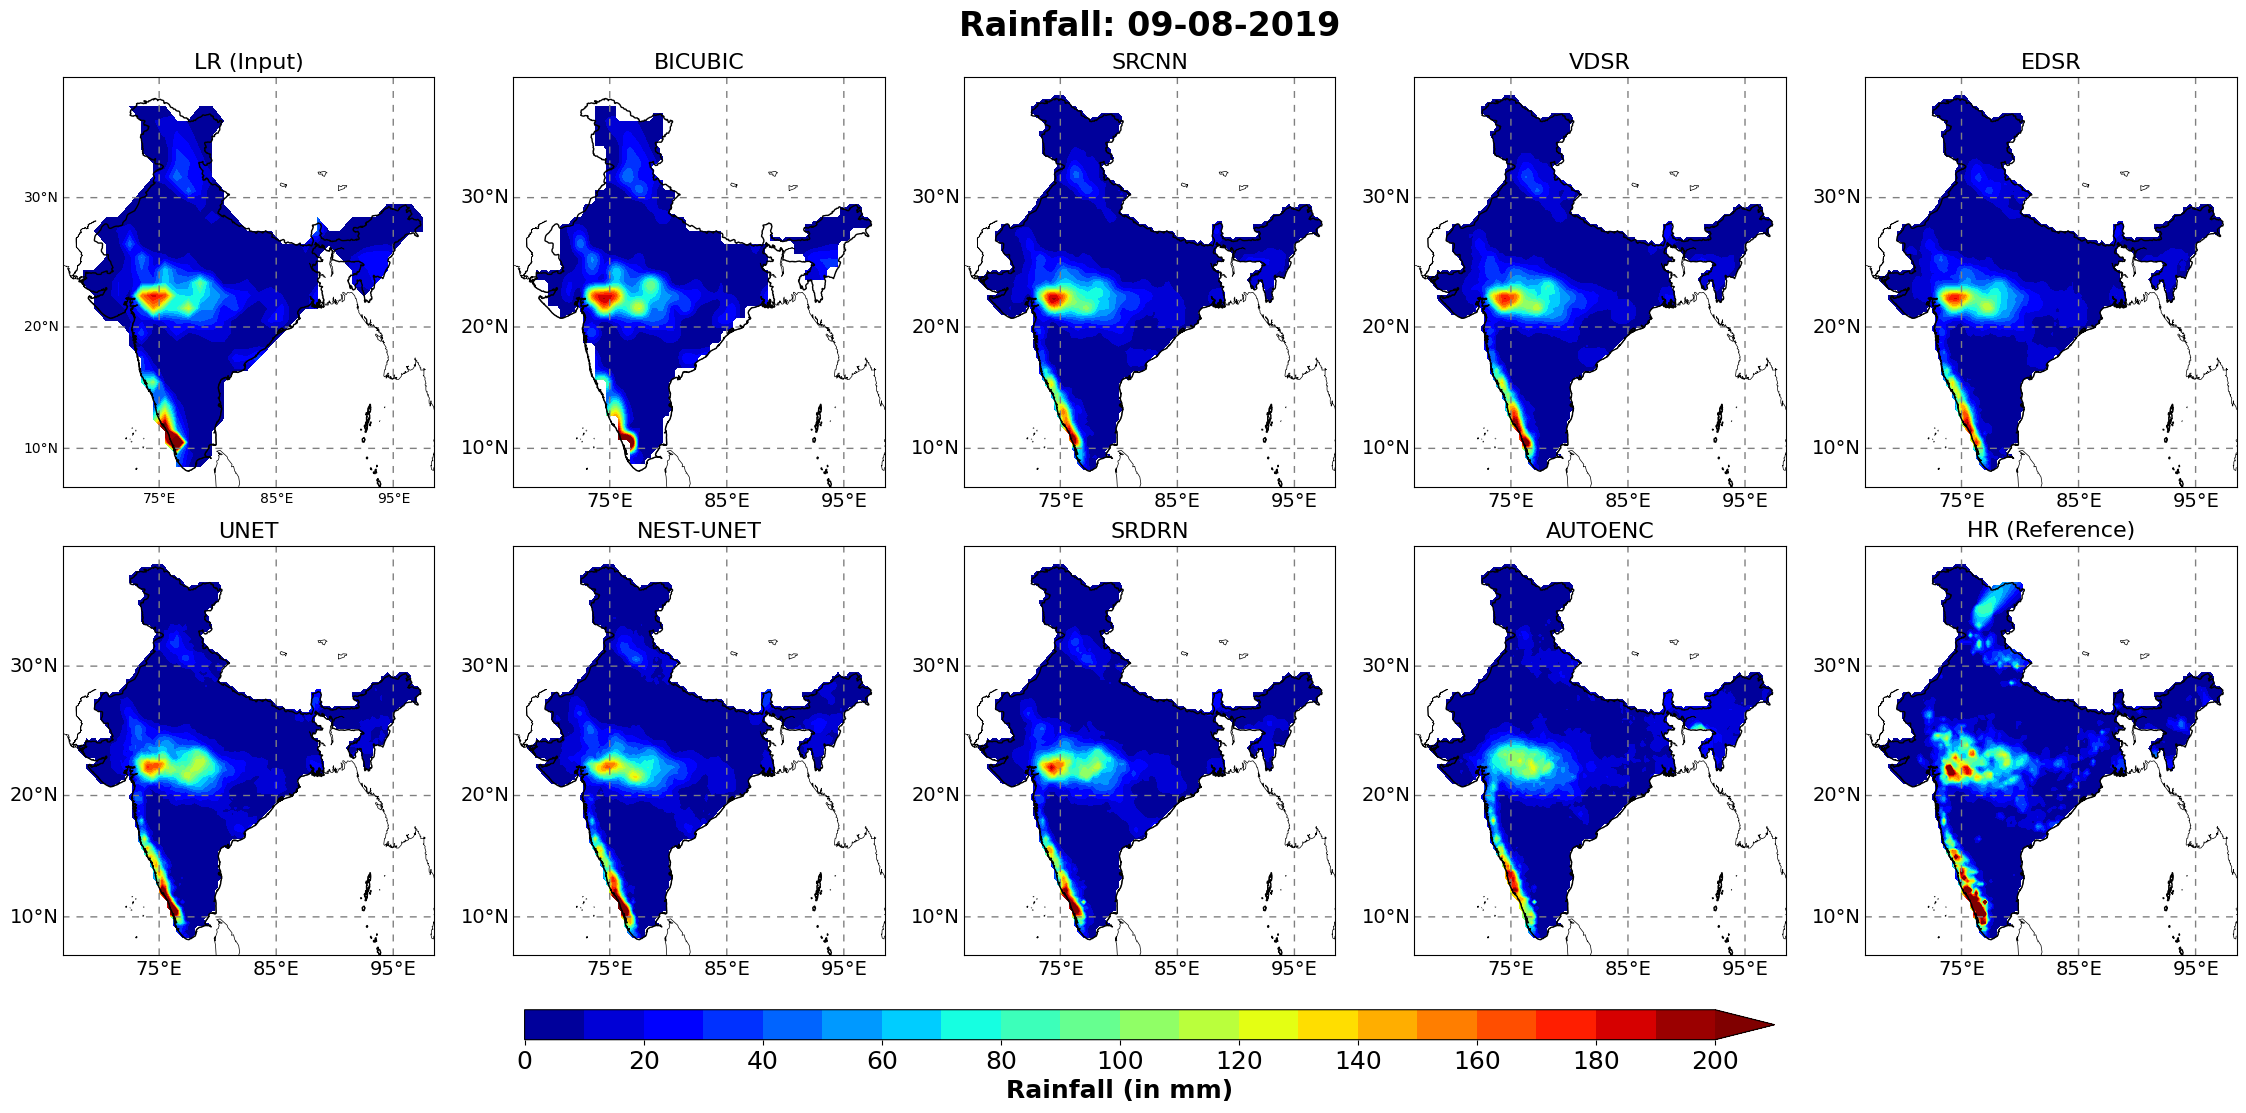

In [6]:
# Plotting code for Figure-5 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC','SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
    ax = fig.add_subplot(2,5,subplot)
    if x != 'NEST_UNET':
      ax.set_title(x, fontsize=16)
    else:
      ax.set_title('NEST-UNET', fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_5a.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-7-e6a53b8b7e47>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


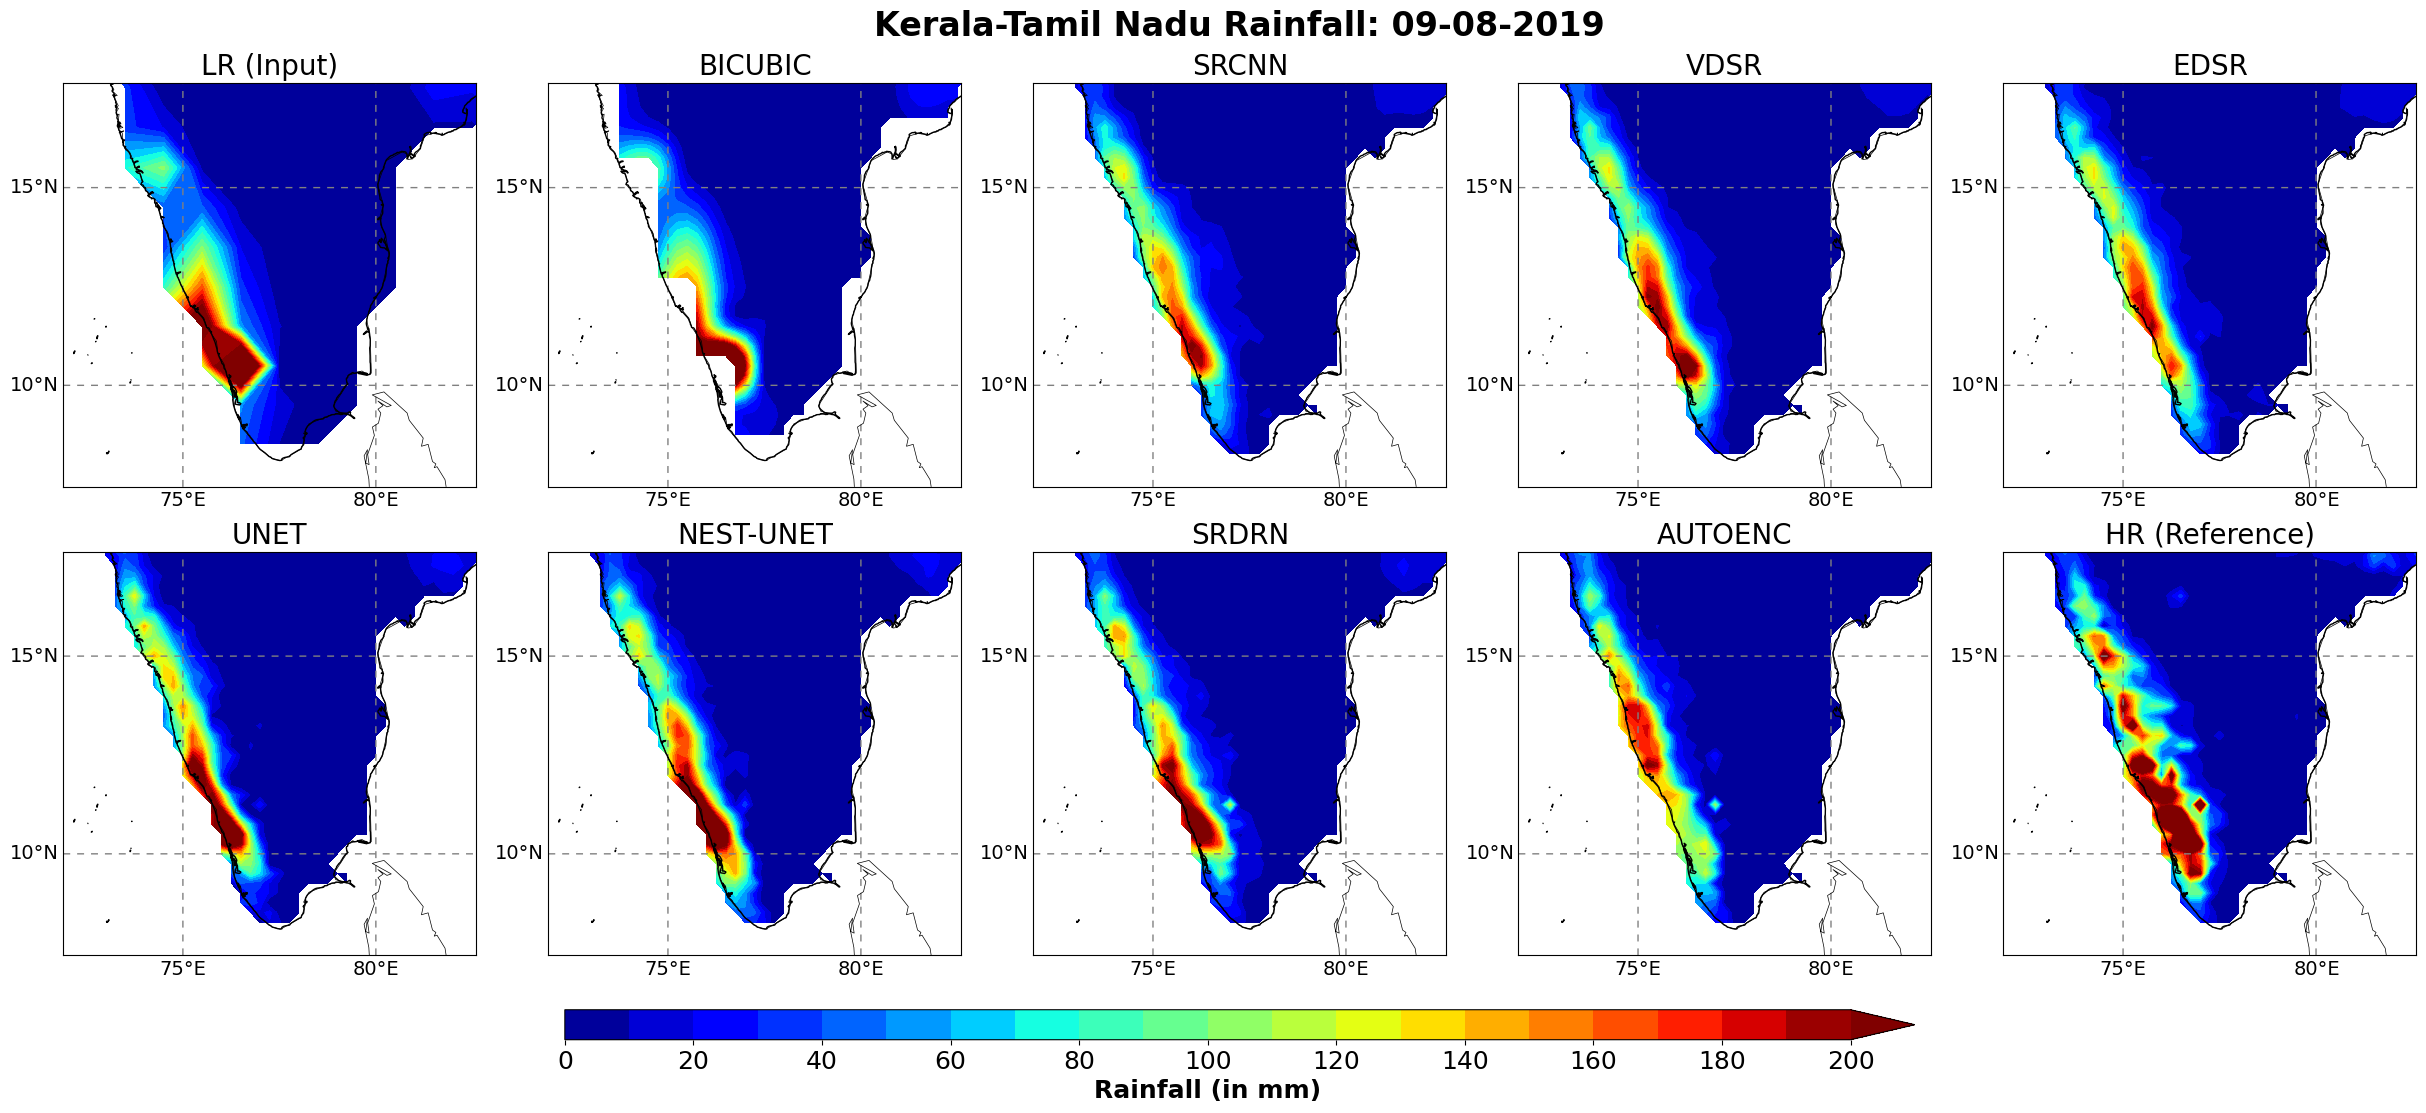

In [7]:
# Plotting code for Figure-5 b)
bm=Basemap(projection='merc',llcrnrlat=7.4,urcrnrlat=17.6,llcrnrlon=71.9,urcrnrlon=82.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(27,10), facecolor = 'white')

fig.suptitle('Kerala-Tamil Nadu Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=20)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=20)
  else:
    ax.set_title('NEST-UNET', fontsize=20)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=20)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('../ANALYSIS/plots/Fig_5b.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-8-f8dbe8a5e07c>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


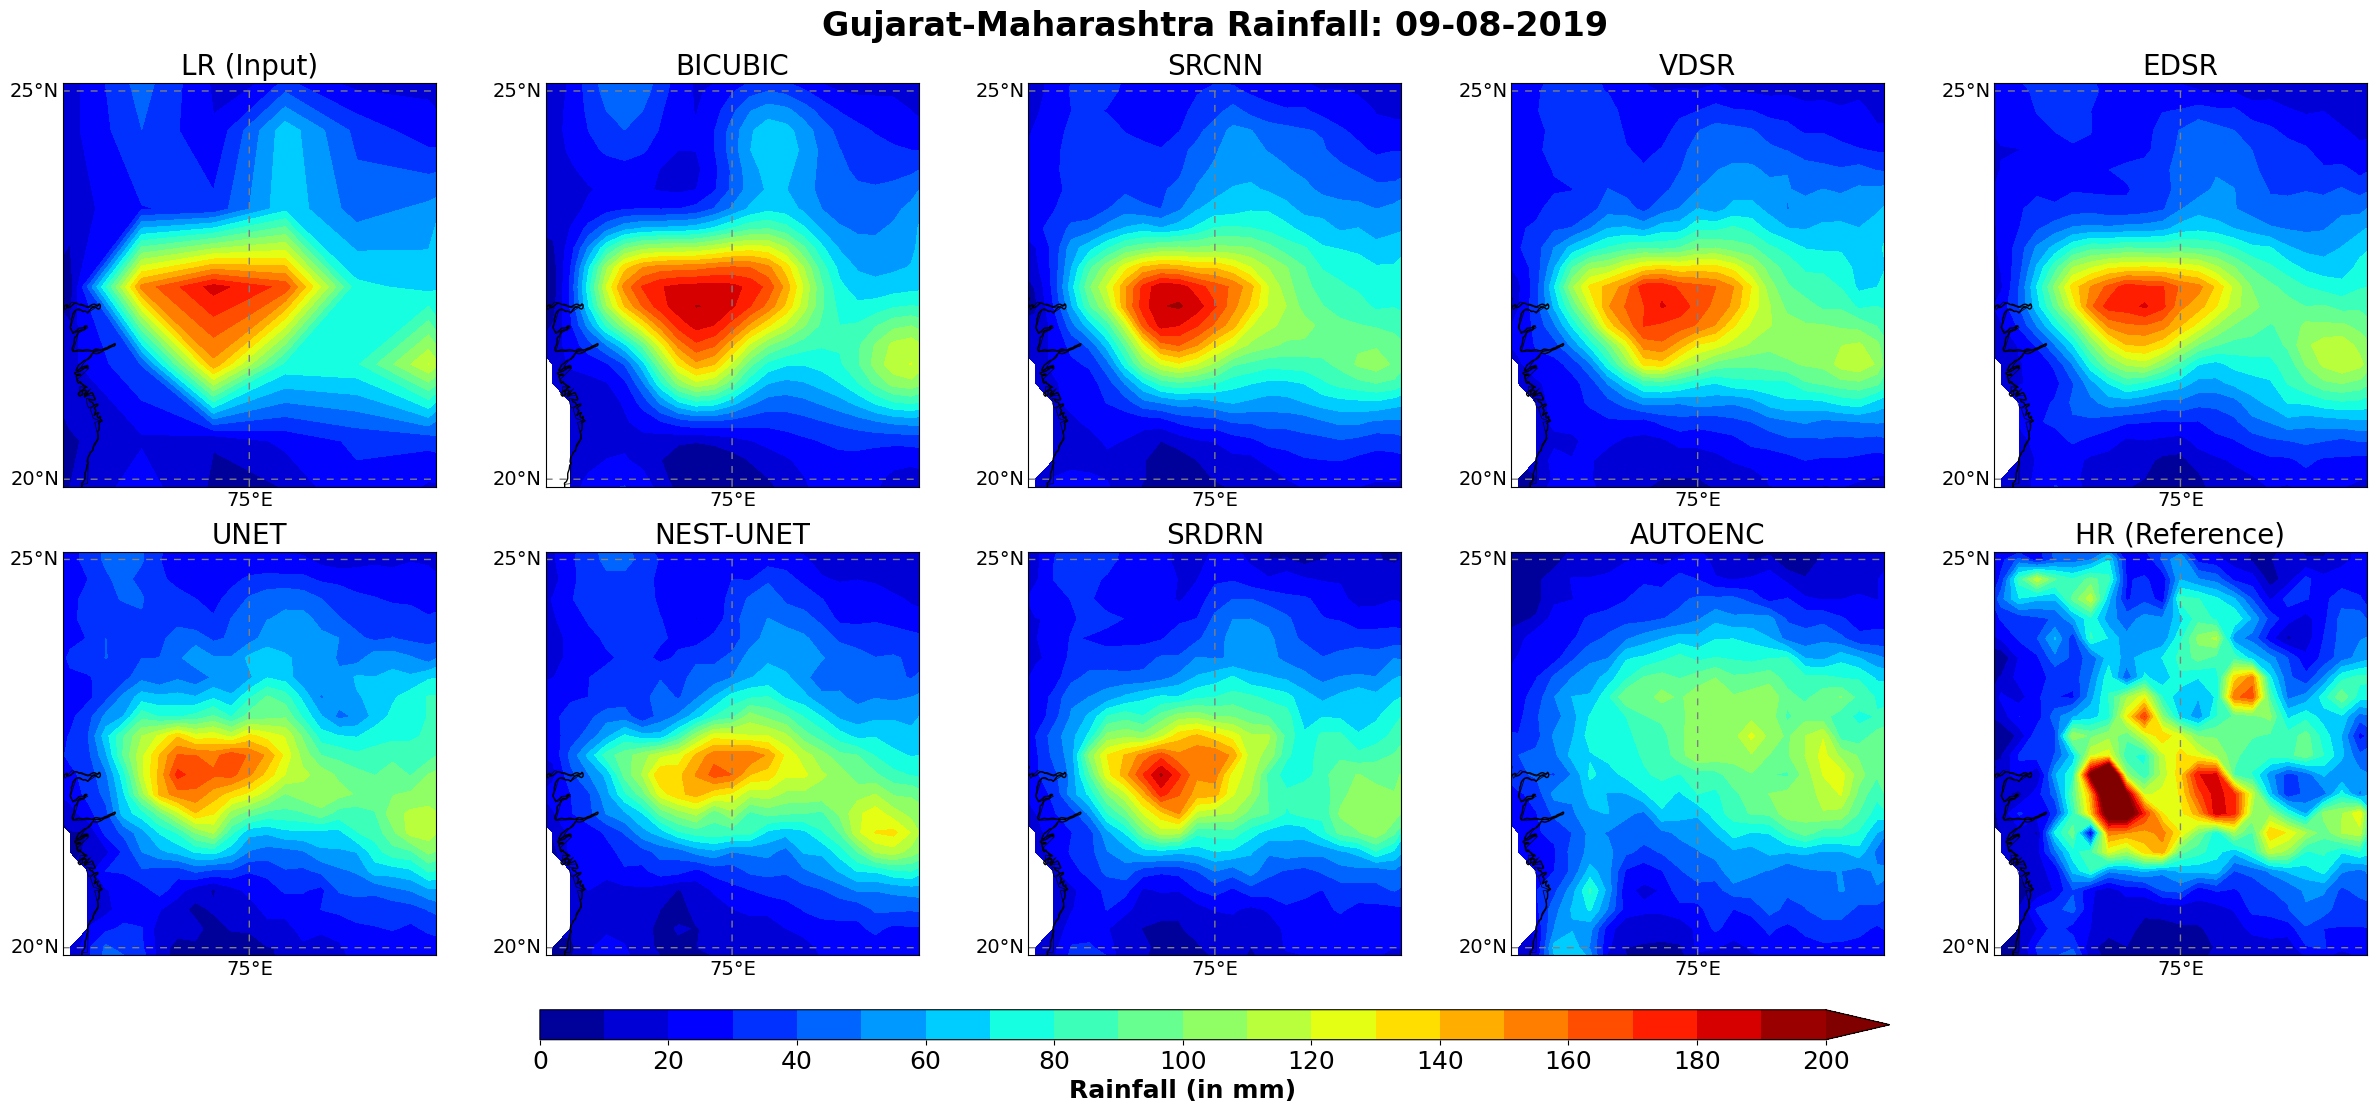

In [8]:
# Plotting code for Figure-5 c)
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=25.1,llcrnrlon=72.4,urcrnrlon=77.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1316
fig= plt.figure(figsize=(27,10), facecolor = 'white')

fig.suptitle('Gujarat-Maharashtra Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=20)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=20)
  else:
    ax.set_title('NEST-UNET', fontsize=20)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=20)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14,dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_5c.png', bbox_inches = 'tight', dpi = 300)

In [9]:
# Saving all the outputs along with groundtruth (gt) into a netCDF file.
ds = xr.Dataset(
    {"gt": (("time", "lat", "lon"), groundtruths*mask_025.reshape((1, 128, 128))),
     "autoenc": (("time", "lat", "lon"), outputs['AUTOENC']*mask_025.reshape((1, 128, 128))),
     "srcnn": (("time", "lat", "lon"), outputs['SRCNN']*mask_025.reshape((1, 128, 128))),
     "vdsr": (("time", "lat", "lon"), outputs['VDSR']*mask_025.reshape((1, 128, 128))),
     "srdrn": (("time", "lat", "lon"), outputs['SRDRN']*mask_025.reshape((1, 128, 128))),
     "edsr": (("time", "lat", "lon"), outputs['EDSR']*mask_025.reshape((1, 128, 128))),
     "unet": (("time", "lat", "lon"), outputs['UNET']*mask_025.reshape((1, 128, 128))),
     "nest_unet": (("time", "lat", "lon"), outputs['NEST_UNET']*mask_025.reshape((1, 128, 128))),
     "bicubic": (("time", "lat", "lon"), outputs['BICUBIC']*mask_025.reshape((1, 128, 128))),
     },
    coords={
        "time": other['dates'],
        "lat": other['lat_025'],
        "lon": other['lon_025'],
    },
)
ds.to_netcdf('./SISR_Outputs.nc')

In [12]:
# Plotting Figure-4
# Calculating fieldmean over the domain for each variable in the SISR_Outputs.nc file for KDE plot.
!cdo fldmean ./SISR_Outputs.nc ./SISR_Outputs_FLDMEAN.nc

cdo    fldmean (Warning): Grid cell bounds not available, using constant grid cell area weights!
cdo    fldmean: Processed 323223552 values from 9 variables over 2192 timesteps [8.32s 4443MB].


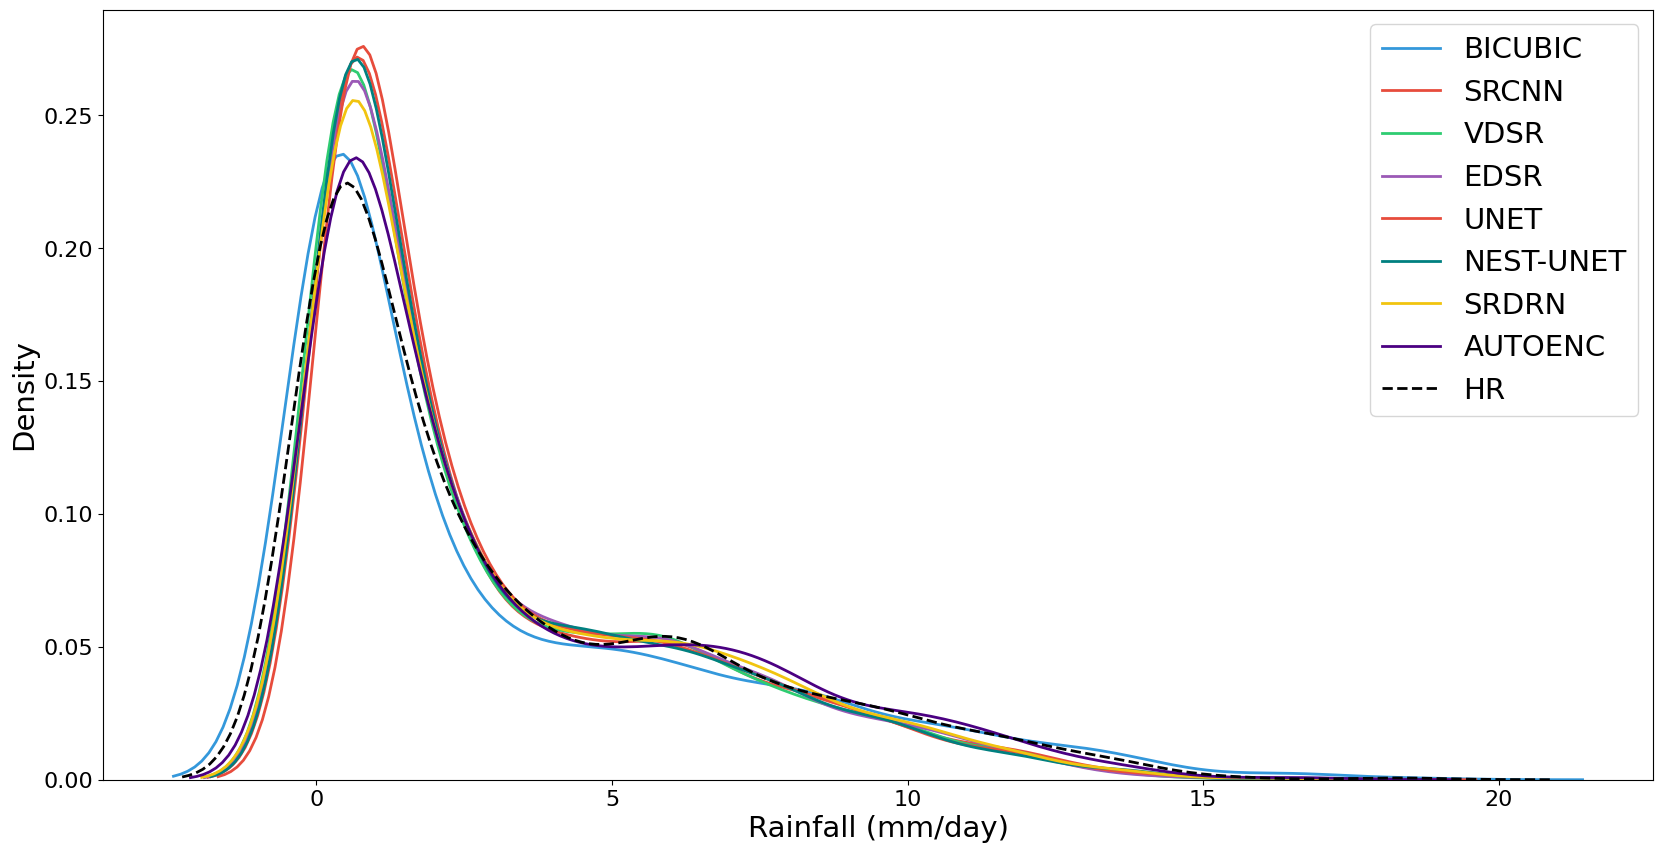

In [13]:
fldmean = xr.open_dataset('./SISR_Outputs_FLDMEAN.nc')
plt.figure(figsize = (20,10), facecolor = 'white')
colors = [
    '#3498db',  # Blue
    '#e74c3c',  # Orange
    '#2ecc71',  # Green
    '#9b59b6',  # Purple
    '#e74c3c',  # Red
    '#008080',  # Teal
    '#f1c40f',  # Yellow
    '#4b0082'   # Indigo
]

sns.kdeplot(fldmean.bicubic.values[:,0,0], lw = 2, color = colors[0])
sns.kdeplot(fldmean.srcnn.values[:,0,0], lw = 2, color = colors[1])
sns.kdeplot(fldmean.vdsr.values[:,0,0], lw = 2, color = colors[2])
sns.kdeplot(fldmean.edsr.values[:,0,0], lw = 2, color = colors[3])
sns.kdeplot(fldmean.unet.values[:,0,0], lw = 2, color = colors[4])
sns.kdeplot(fldmean.nest_unet.values[:,0,0], lw = 2, color = colors[5])
sns.kdeplot(fldmean.srdrn.values[:,0,0], lw = 2, color = colors[6])
sns.kdeplot(fldmean.autoenc.values[:,0,0], lw = 2, color = colors[7])
sns.kdeplot(list(np.squeeze(fldmean.gt.values)), linestyle = '--', color = 'black', lw = 2)
plt.legend(['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST-UNET', 'SRDRN', 'AUTOENC', 'HR'], prop={'size': 21})
plt.xlabel('Rainfall (mm/day)', fontsize = 21)
plt.ylabel('Density', fontsize = 21)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('./plots/Fig_4.png', bbox_inches = 'tight', dpi = 300)

In [14]:
## CALCULATING SPATIAL CORRELATION MAPS:
correlations, pvalues = {}, {}
count = 0
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
    correlations[x] = np.zeros((128,128))
    pvalues[x] = np.zeros((128,128))
    gt = np.where(np.isnan(groundtruths), 0, groundtruths)
    modelled = np.where(np.isnan(outputs[x]), 0, outputs[x])
    for i in tqdm(range(128)):
      for j in range(128):
        pearsonr_stat = scipy.stats.pearsonr(gt[:,i,j], modelled[:,i,j])
        correlations[x][i,j] = pearsonr_stat.correlation
        pvalues[x][i,j] = pearsonr_stat.pvalue

np.savez('./pearsonr_all_models.npz', correlations = correlations, pvalues = pvalues)

  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 128/128 [00:09<00:00, 14.08it/s]


<ipython-input-15-c9f3ee71b7a2>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


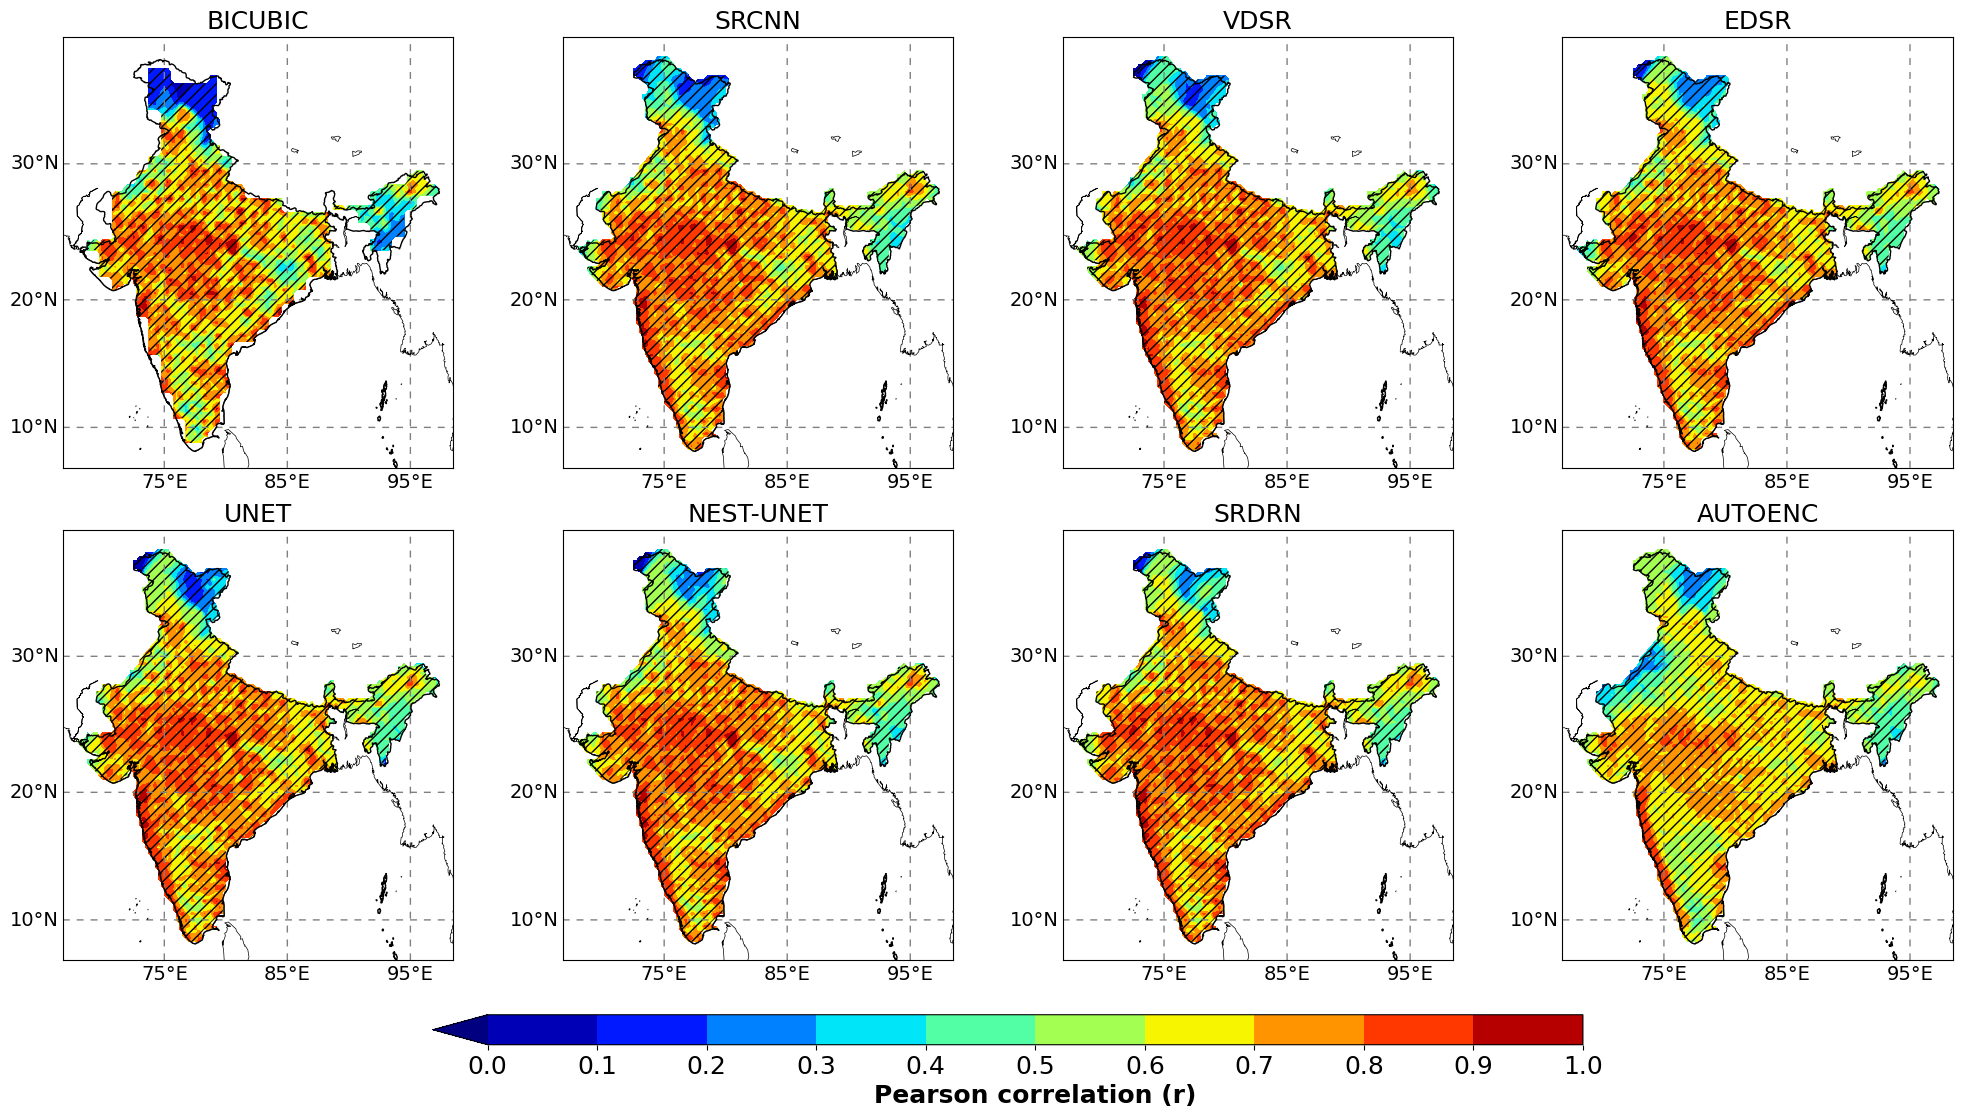

In [15]:
# Plotting Figure 3: correlation maps with significant values (p <= 0.05) as hatches.
# Basemap Plots
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

xi, yi = bm(lons_025, lats_025)

fig= plt.figure(figsize=(23,10), facecolor = 'white')
subplot = 1
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,4,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=18)
  else:
    ax.set_title('NEST-UNET', fontsize=18)
  colormap = bm.contourf(xi,yi,np.squeeze(correlations[x]*mask_025), contour_levels, cmap='jet', extend = 'min')
  bm.contourf(xi,yi,pvalues[x], levels = [0,0.05,1], colors = 'none', hatches = ['///', None])
  bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Pearson correlation (r)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_3.png', bbox_inches = 'tight', dpi = 300)

## **Calculating Error Metrics**

In [16]:
# Flatten and remove NaN values.
def flat_nan_rem(arr):
  # Setting all existing nan values to zero first to ensure all the flattened arrays (post-nan removal) are of same shape
  arr = np.where(np.isnan(arr),0,arr)
  arr = (arr*mask_025).flatten()
  return arr[np.where(~np.isnan(arr))]

In [17]:
# Defining all the metrics.

def correlation_coefficient(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the covariance and the standard deviations of the two arrays
    cov = np.cov(model, gt)
    std_model = np.std(model)
    std_gt = np.std(gt)
    # Calculate the correlation coefficient
    corr_coef = cov[0][1] / (std_model * std_gt)
    return np.round(corr_coef, 4)

def mean_absolute_error(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the absolute differences between the values in the two arrays
    abs_diff = np.abs(model - gt)
    # Calculate the mean absolute error
    mae = np.mean(abs_diff)
    return np.round(mae, 4)

def root_mean_square_error(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the squared differences between the values in the two arrays
    sq_diff = (model - gt) ** 2
    # Calculate the root mean square error
    rmse = np.sqrt(np.mean(sq_diff))
    return np.round(rmse,4)

def coefficient_of_determination(model, gt):
    # Calculate the correlation coefficient between the two arrays
    corr_coef = correlation_coefficient(model, gt)
    # Calculate the coefficient of determination
    r_squared = corr_coef ** 2
    return np.round(r_squared, 4)

def bias(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the difference between the values in the two arrays
    diff = model - gt
    # Calculate the bias
    bias = np.mean(diff)
    return np.round(bias,4)

def psnr(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # calculate the MSE
    mse = np.mean((model - gt) ** 2)
    # calculate the maximum pixel value
    max_pixel = np.max(gt)
    # calculate the PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return np.round(psnr,4)

def percent_bias(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the mean of the observed values and the modeled values
    obs_mean = np.mean(gt)
    model_mean = np.mean(model)
    # Calculate the difference between the modeled values and the observed values
    diff = model - gt
    # Calculate the sum of the differences
    diff_sum = np.sum(diff)
    # Calculate the sum of the observed values
    obs_sum = np.sum(gt)
    # Calculate the percent bias
    pbias = 100 * (diff_sum / obs_sum)
    return np.round(pbias,4)

def cosine_similarity(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the dot product of the two arrays
    dot_product = np.dot(model, gt)
    # Calculate the magnitudes of the two arrays
    model_mag = np.sqrt(np.sum(model**2))
    gt_mag = np.sqrt(np.sum(gt**2))
    # Calculate the cosine similarity
    cosine_sim = dot_product / (model_mag * gt_mag)
    return np.round(cosine_sim, 4)

def ttest_ind(model, gt):
    model = flat_nan_rem(model)
    gt = flat_nan_rem(gt)
    # Calculate the T-test
    ttest_ind = scipy.stats.ttest_ind(model,gt)
    return [np.round(ttest_ind.statistic, 4), ttest_ind.pvalue]

In [18]:
# Defining error metrics table.
df = pd.DataFrame(columns = ['Model', 'r', 'MAE', 'RMSE', 'r^2', 'Bias', 'PBIAS', 'PSNR', 'Cosine Similarity', 'T-test (statistic)', 'T-test (p-value)'])
# Function to calculate all metrics at same time for a particular model output-gt combination.
def calc_metrics(exp, model, obs, df):
    df.loc[len(df)] = [exp, correlation_coefficient(model, obs), mean_absolute_error(model, obs), root_mean_square_error(model, obs),
               coefficient_of_determination(model, obs), bias(model, obs), percent_bias(model, obs), psnr(model, obs), cosine_similarity(model, obs)] + ttest_ind(model,obs)
# Calculating the metrics.
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  calc_metrics(x, outputs[x], groundtruths, df)

In [19]:
df

Model       r     MAE     RMSE     r^2    Bias    PBIAS     PSNR  \
0    BICUBIC  0.5361  2.9787  10.0752  0.2874 -0.4314 -13.5123  36.5044   
1      SRCNN  0.7065  2.6550   7.8441  0.4991 -0.2323  -7.2757  38.6786   
2       VDSR  0.7102  2.5793   7.8039  0.5044 -0.2935  -9.1952  38.7232   
3       EDSR  0.7181  2.6040   7.7188  0.5157 -0.2325  -7.2841  38.8184   
4       UNET  0.7148  2.6411   7.7345  0.5109 -0.1897  -5.9422  38.8008   
5  NEST_UNET  0.7125  2.5936   7.7688  0.5077 -0.2615  -8.1921  38.7624   
6      SRDRN  0.7288  2.5609   7.5796  0.5311 -0.1595  -4.9961  38.9765   
7    AUTOENC  0.6726  3.0028   8.1816  0.4524  0.0662   2.0728  38.3127   

   Cosine Similarity  T-test (statistic)  T-test (p-value)  
0             0.5713            -96.7584      0.000000e+00  
1             0.7333            -57.8358      0.000000e+00  
2             0.7365            -72.8962      0.000000e+00  
3             0.7436            -57.7307      0.000000e+00  
4             0.7406            -46.3117      0.000000e+00  
5             0.7385            -64.4420      0.000000e+00  
6             0.7531            -39.0123      0.000000e+00  
7             0.7032             16.4224      1.323774e-60

In [20]:
# Saving these metrics to a .csv file.
df.to_csv('./SISR_Error_Metrics.csv')

### **Supplementary Figures**

<ipython-input-21-231710063d3a>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


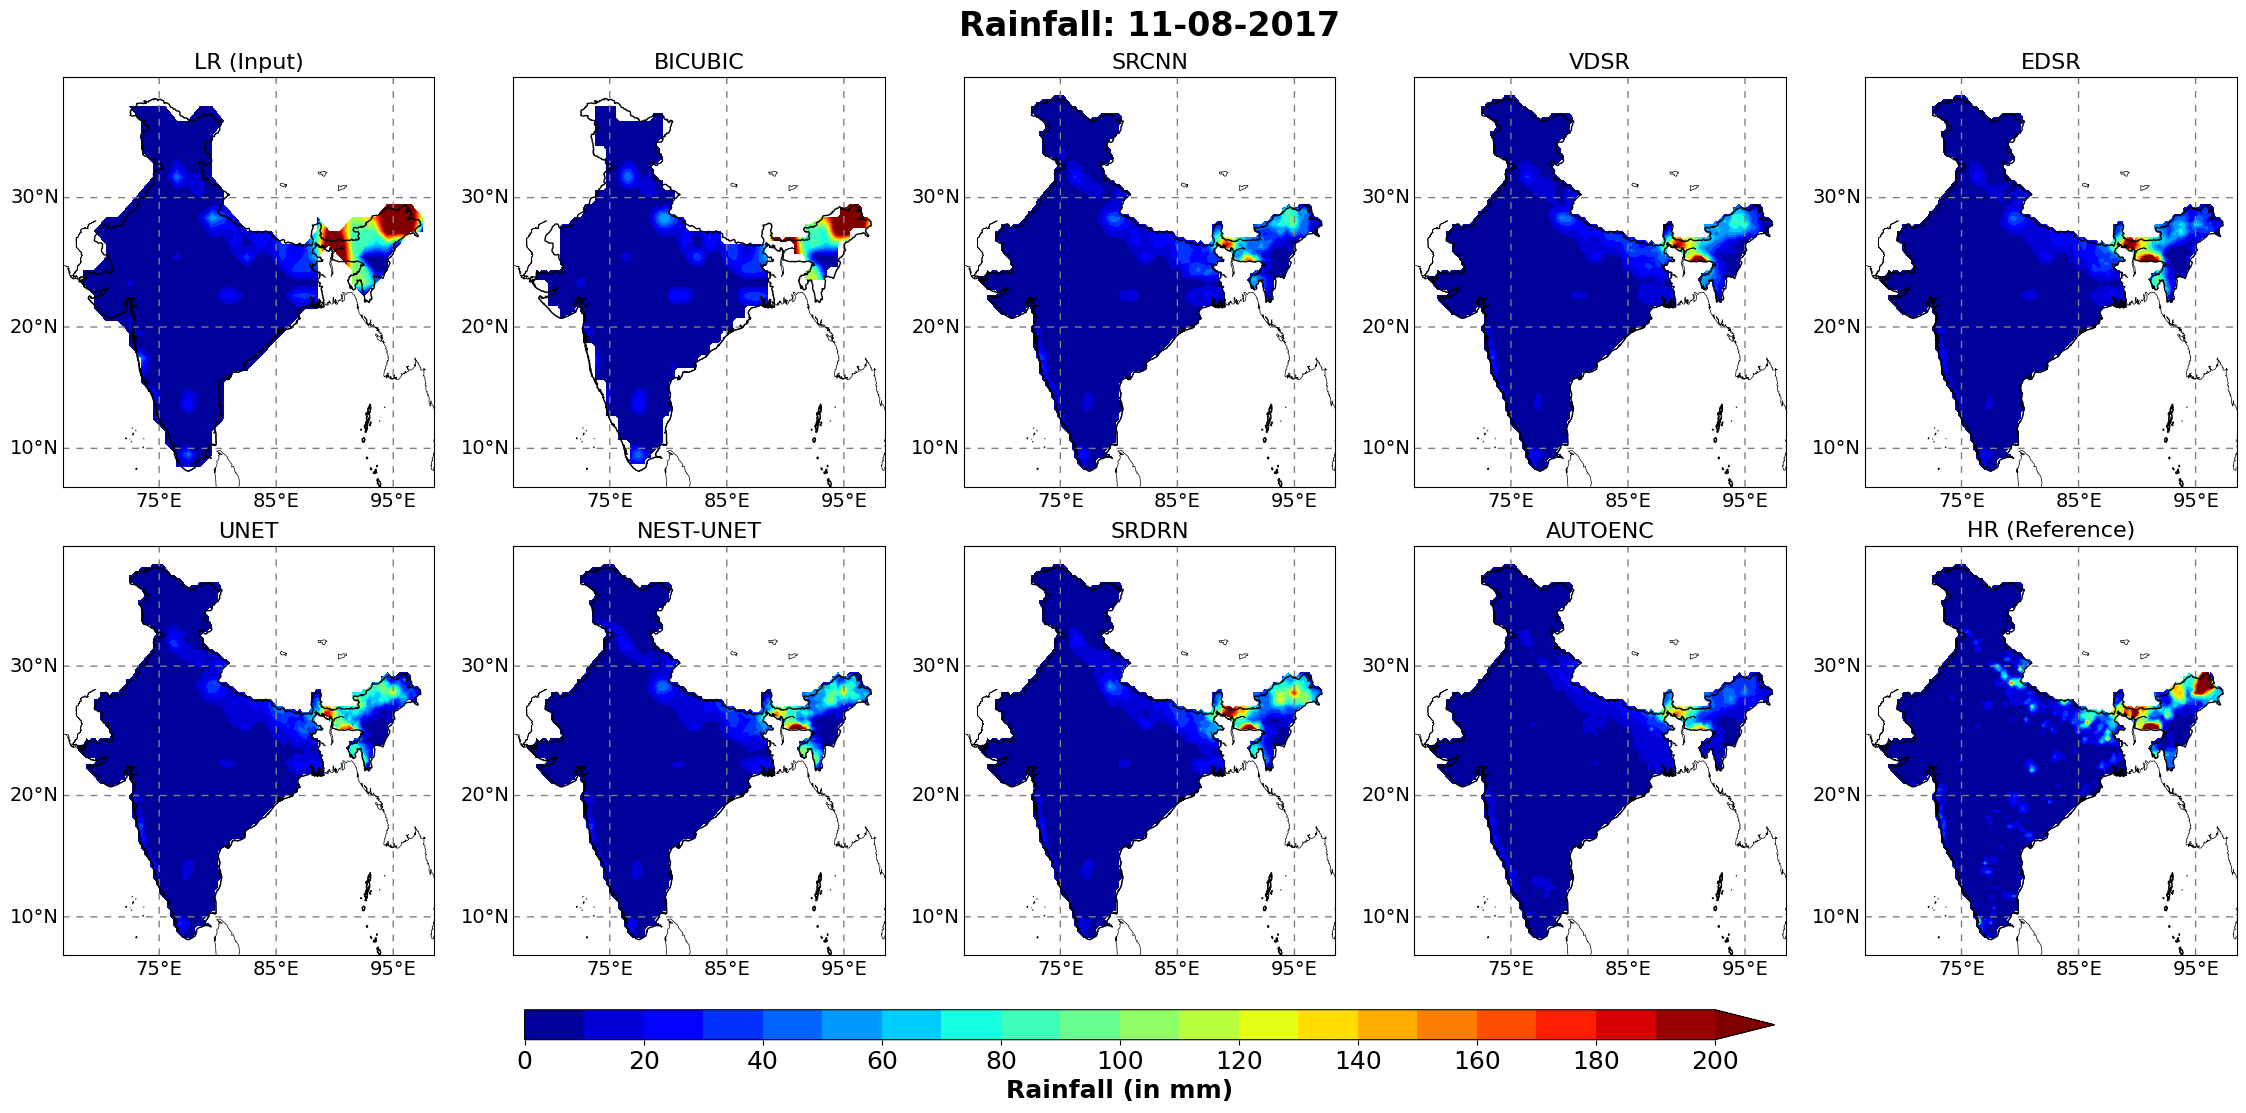

In [21]:
# Plotting Supplementary Figures
# Figure S1 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 588
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
    ax = fig.add_subplot(2,5,subplot)
    if x != 'NEST_UNET':
      ax.set_title(x, fontsize=16)
    else:
      ax.set_title('NEST-UNET', fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S1a.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-22-6505d97c701a>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


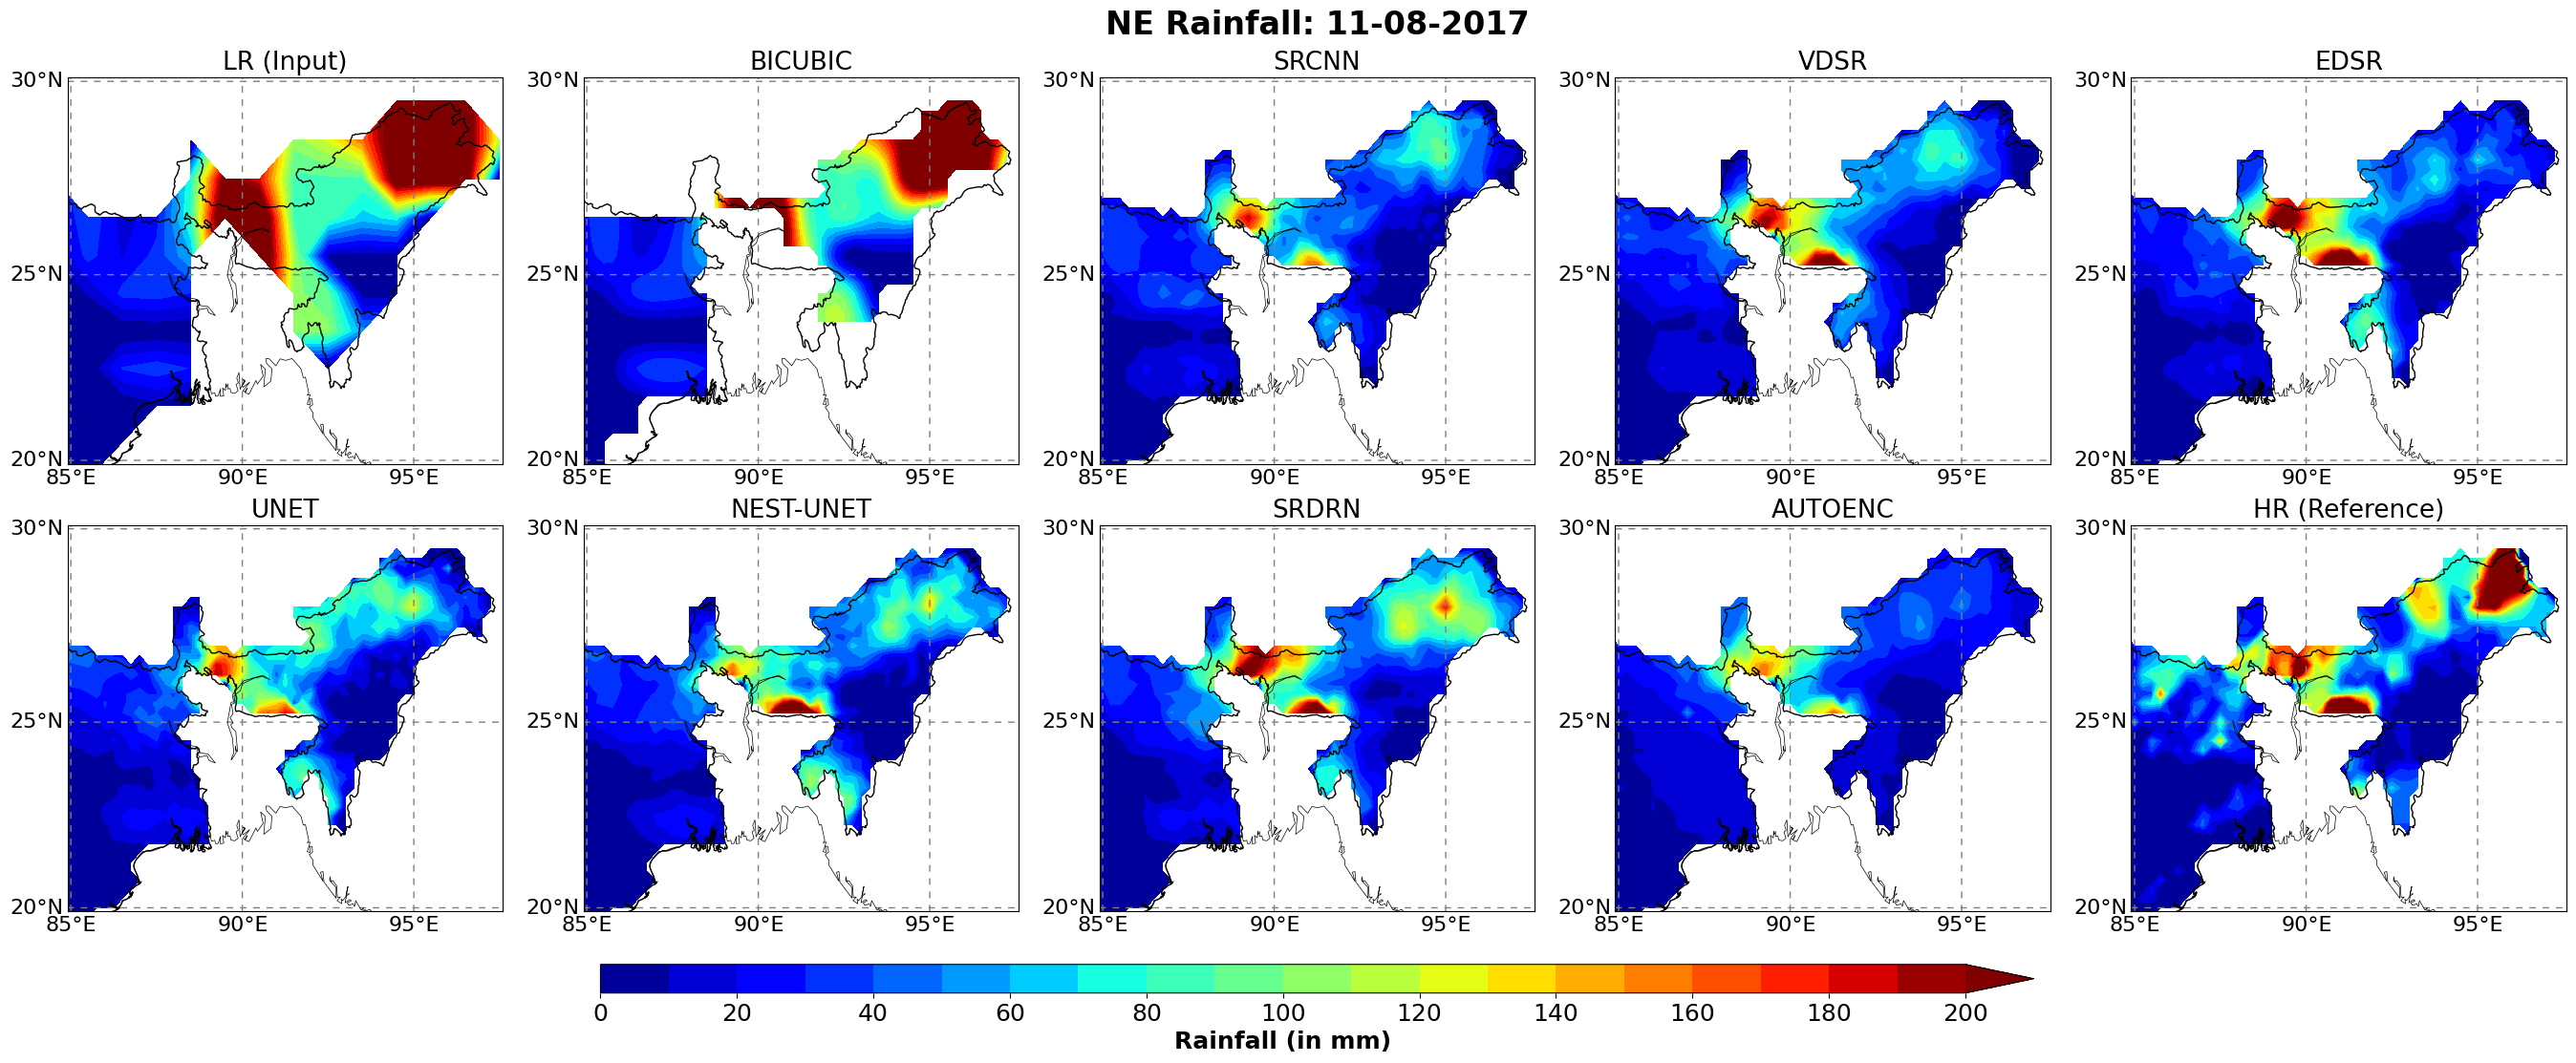

In [22]:
# Figure S1 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=30.1,llcrnrlon=84.9,urcrnrlon=97.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 588
fig= plt.figure(figsize=(30,10), facecolor = 'white')

fig.suptitle('NE Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=19)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=19)
  else:
    ax.set_title('NEST-UNET', fontsize=19)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=19)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S1b.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-23-33a6c646f11a>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


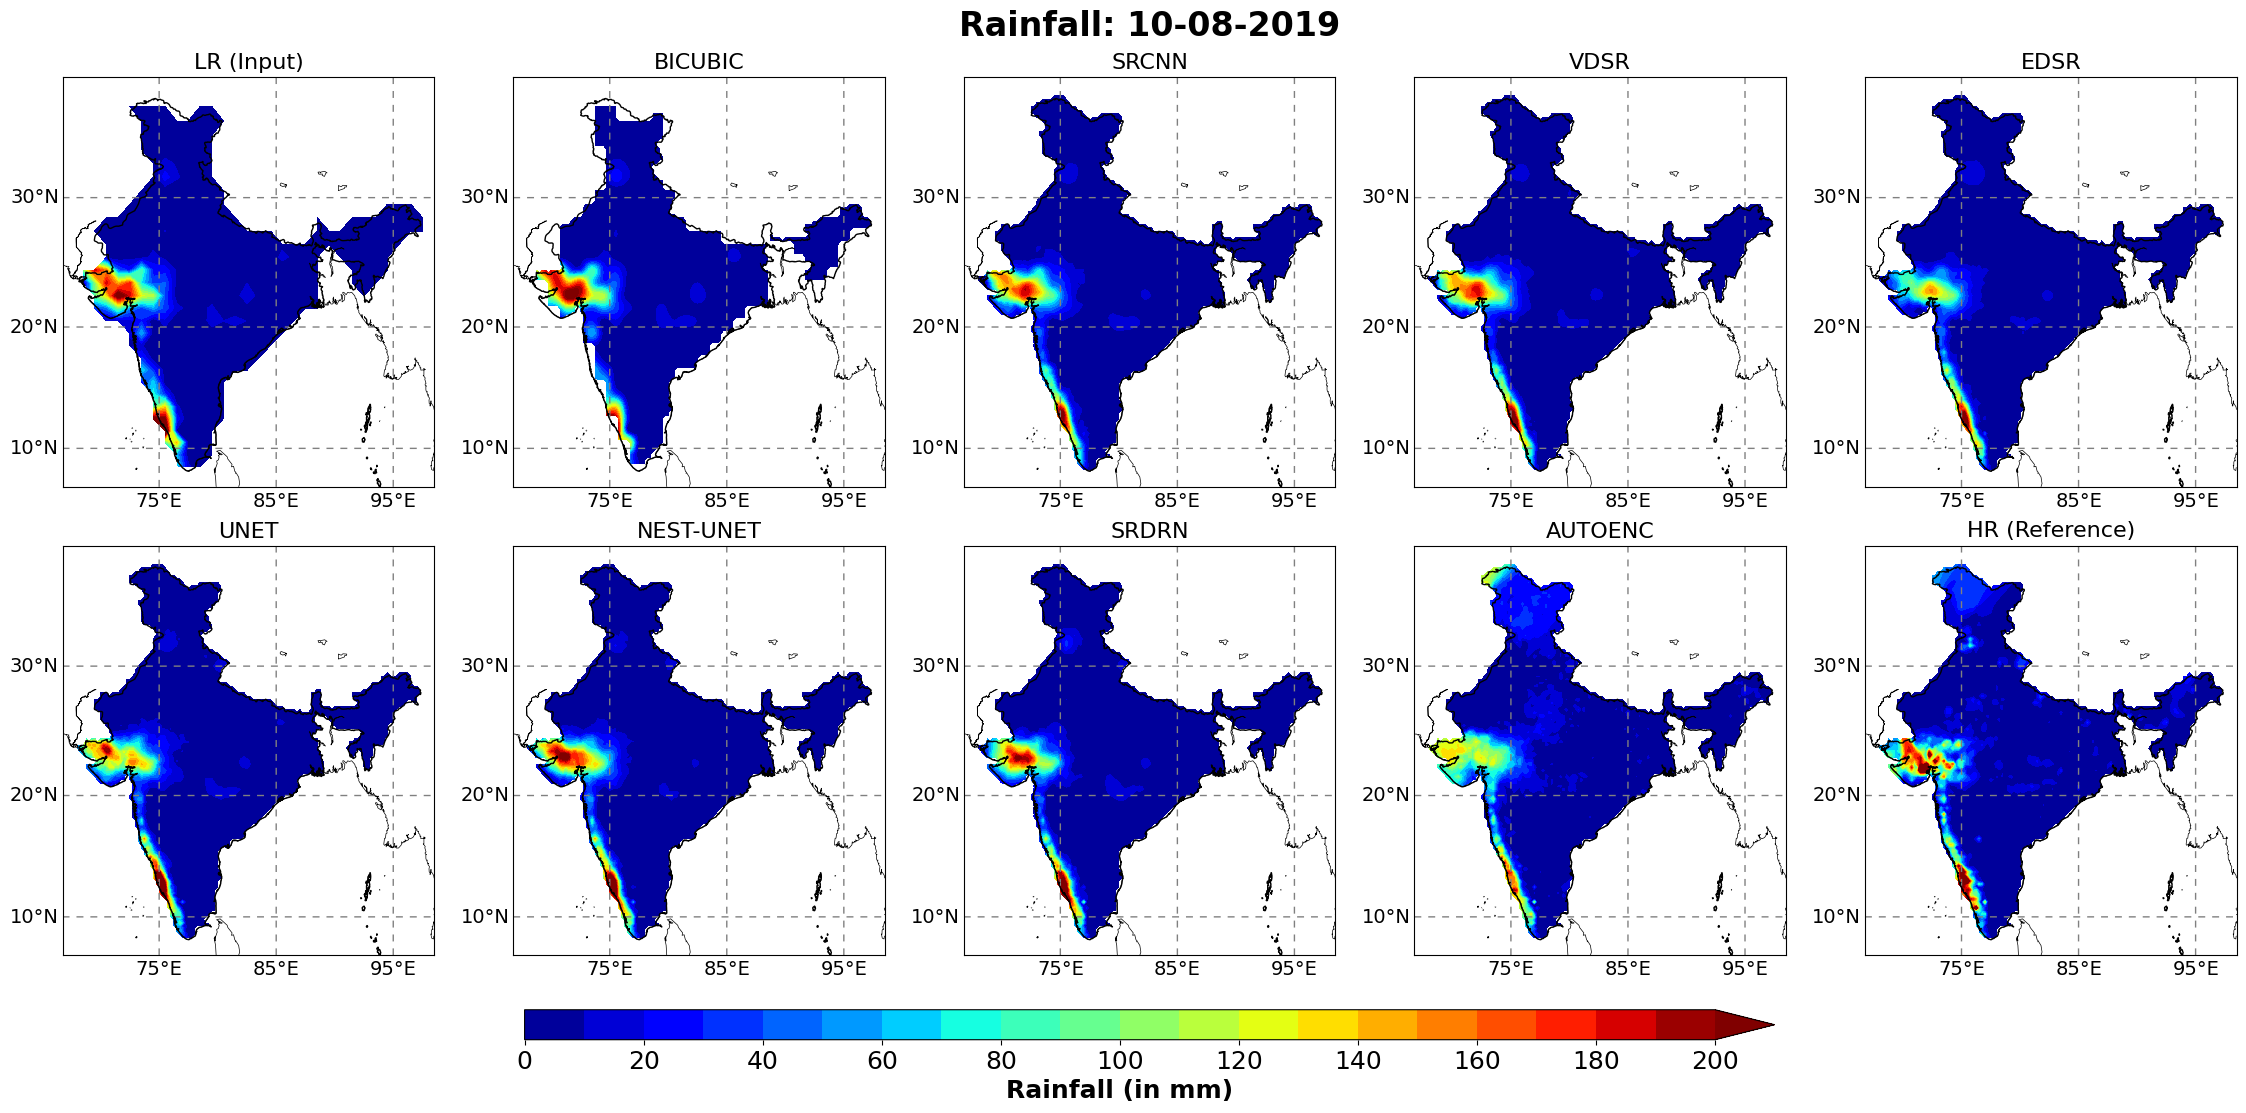

In [23]:
# Plotting Supplementary Figures
# Figure S2 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
    ax = fig.add_subplot(2,5,subplot)
    if x != 'NEST_UNET':
      ax.set_title(x, fontsize=16)
    else:
      ax.set_title('NEST-UNET', fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S2a.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-24-ebefa67a88a2>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


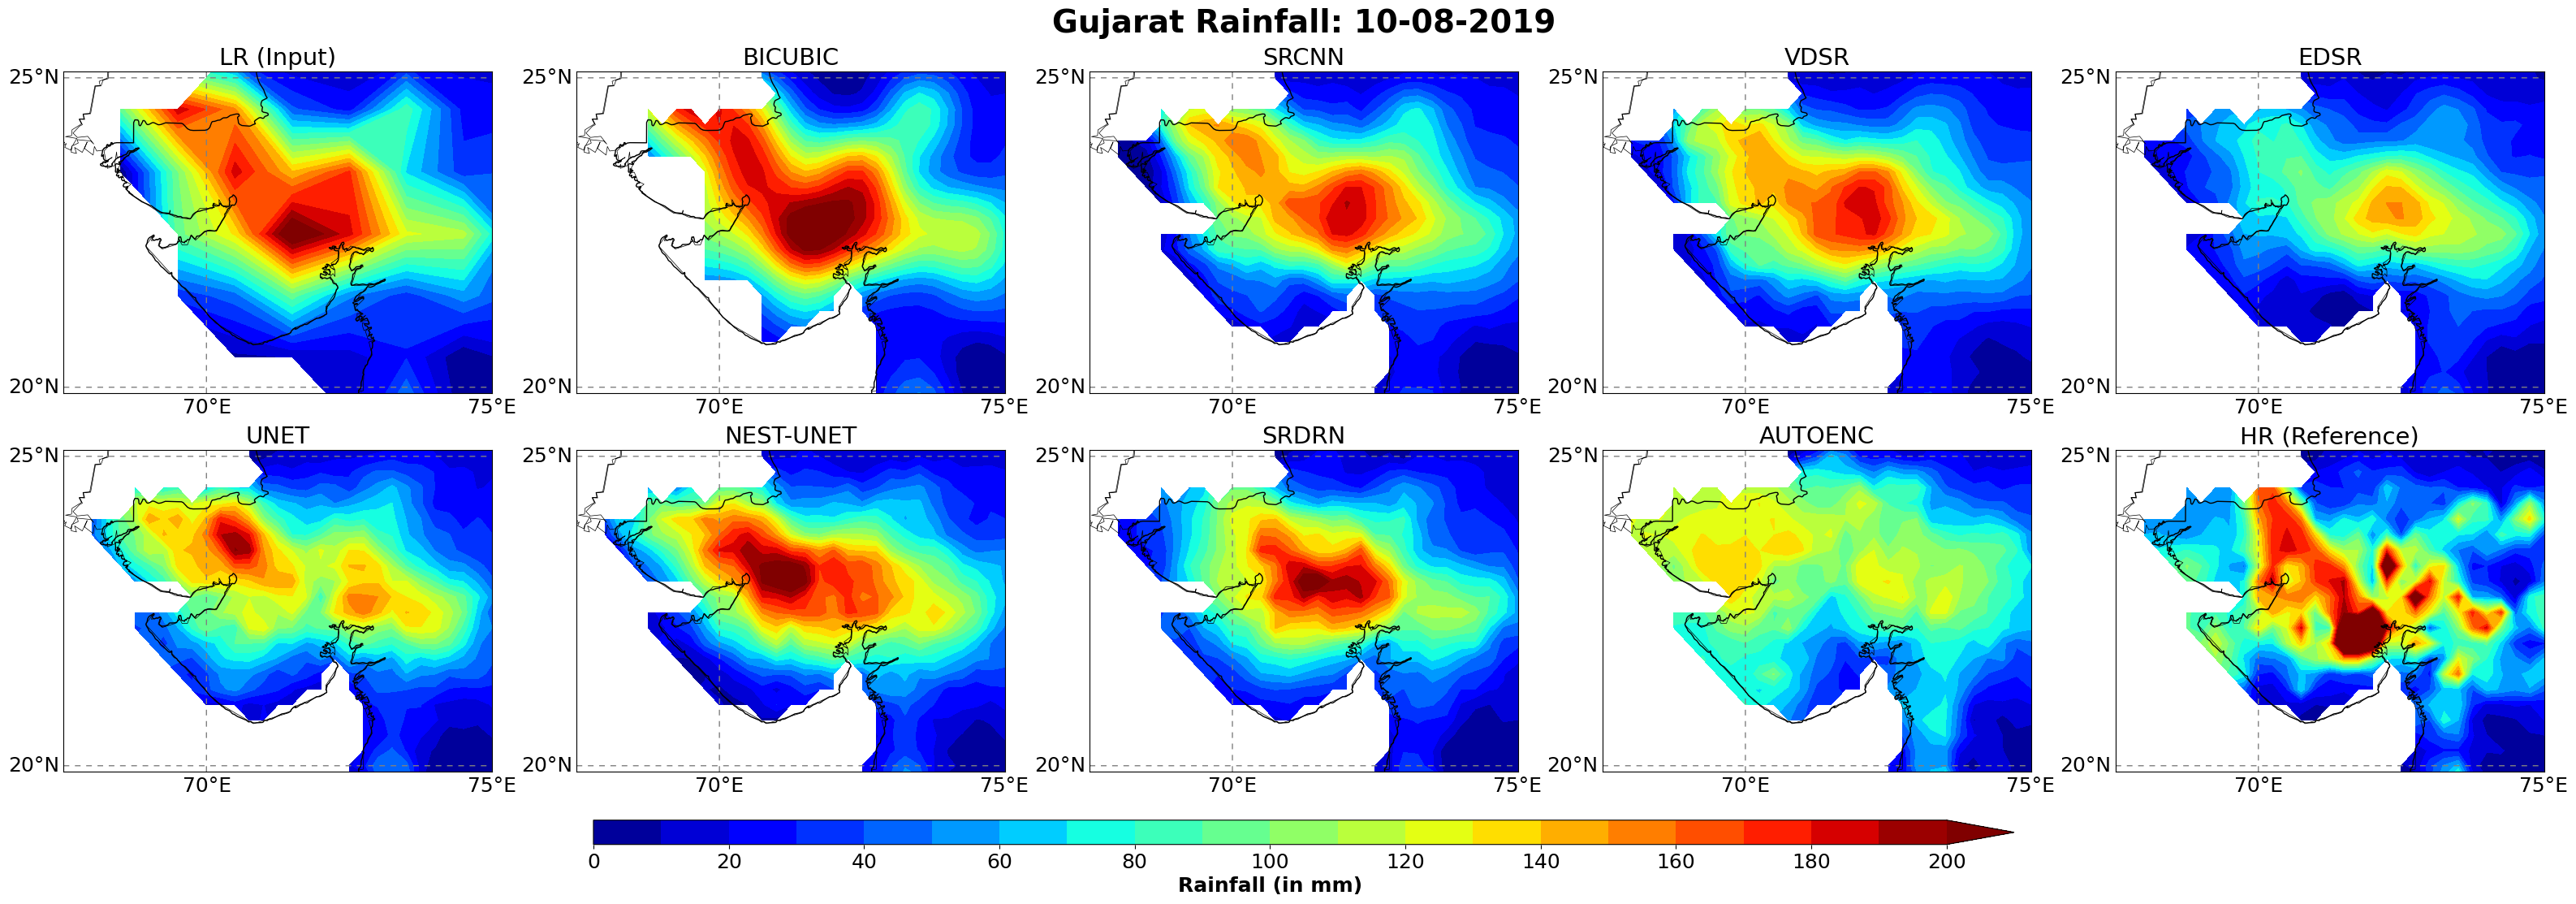

In [24]:
# Figure S2 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=19.9,urcrnrlat=25.1,llcrnrlon=67.5,urcrnrlon=75, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(35,10), facecolor = 'white')

fig.suptitle('Gujarat Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 28, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=21)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 18, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 18, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=21)
  else:
    ax.set_title('NEST-UNET', fontsize=21)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 18, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 18, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=21)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 18, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 18, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S2b.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-25-ecfb210d7de6>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


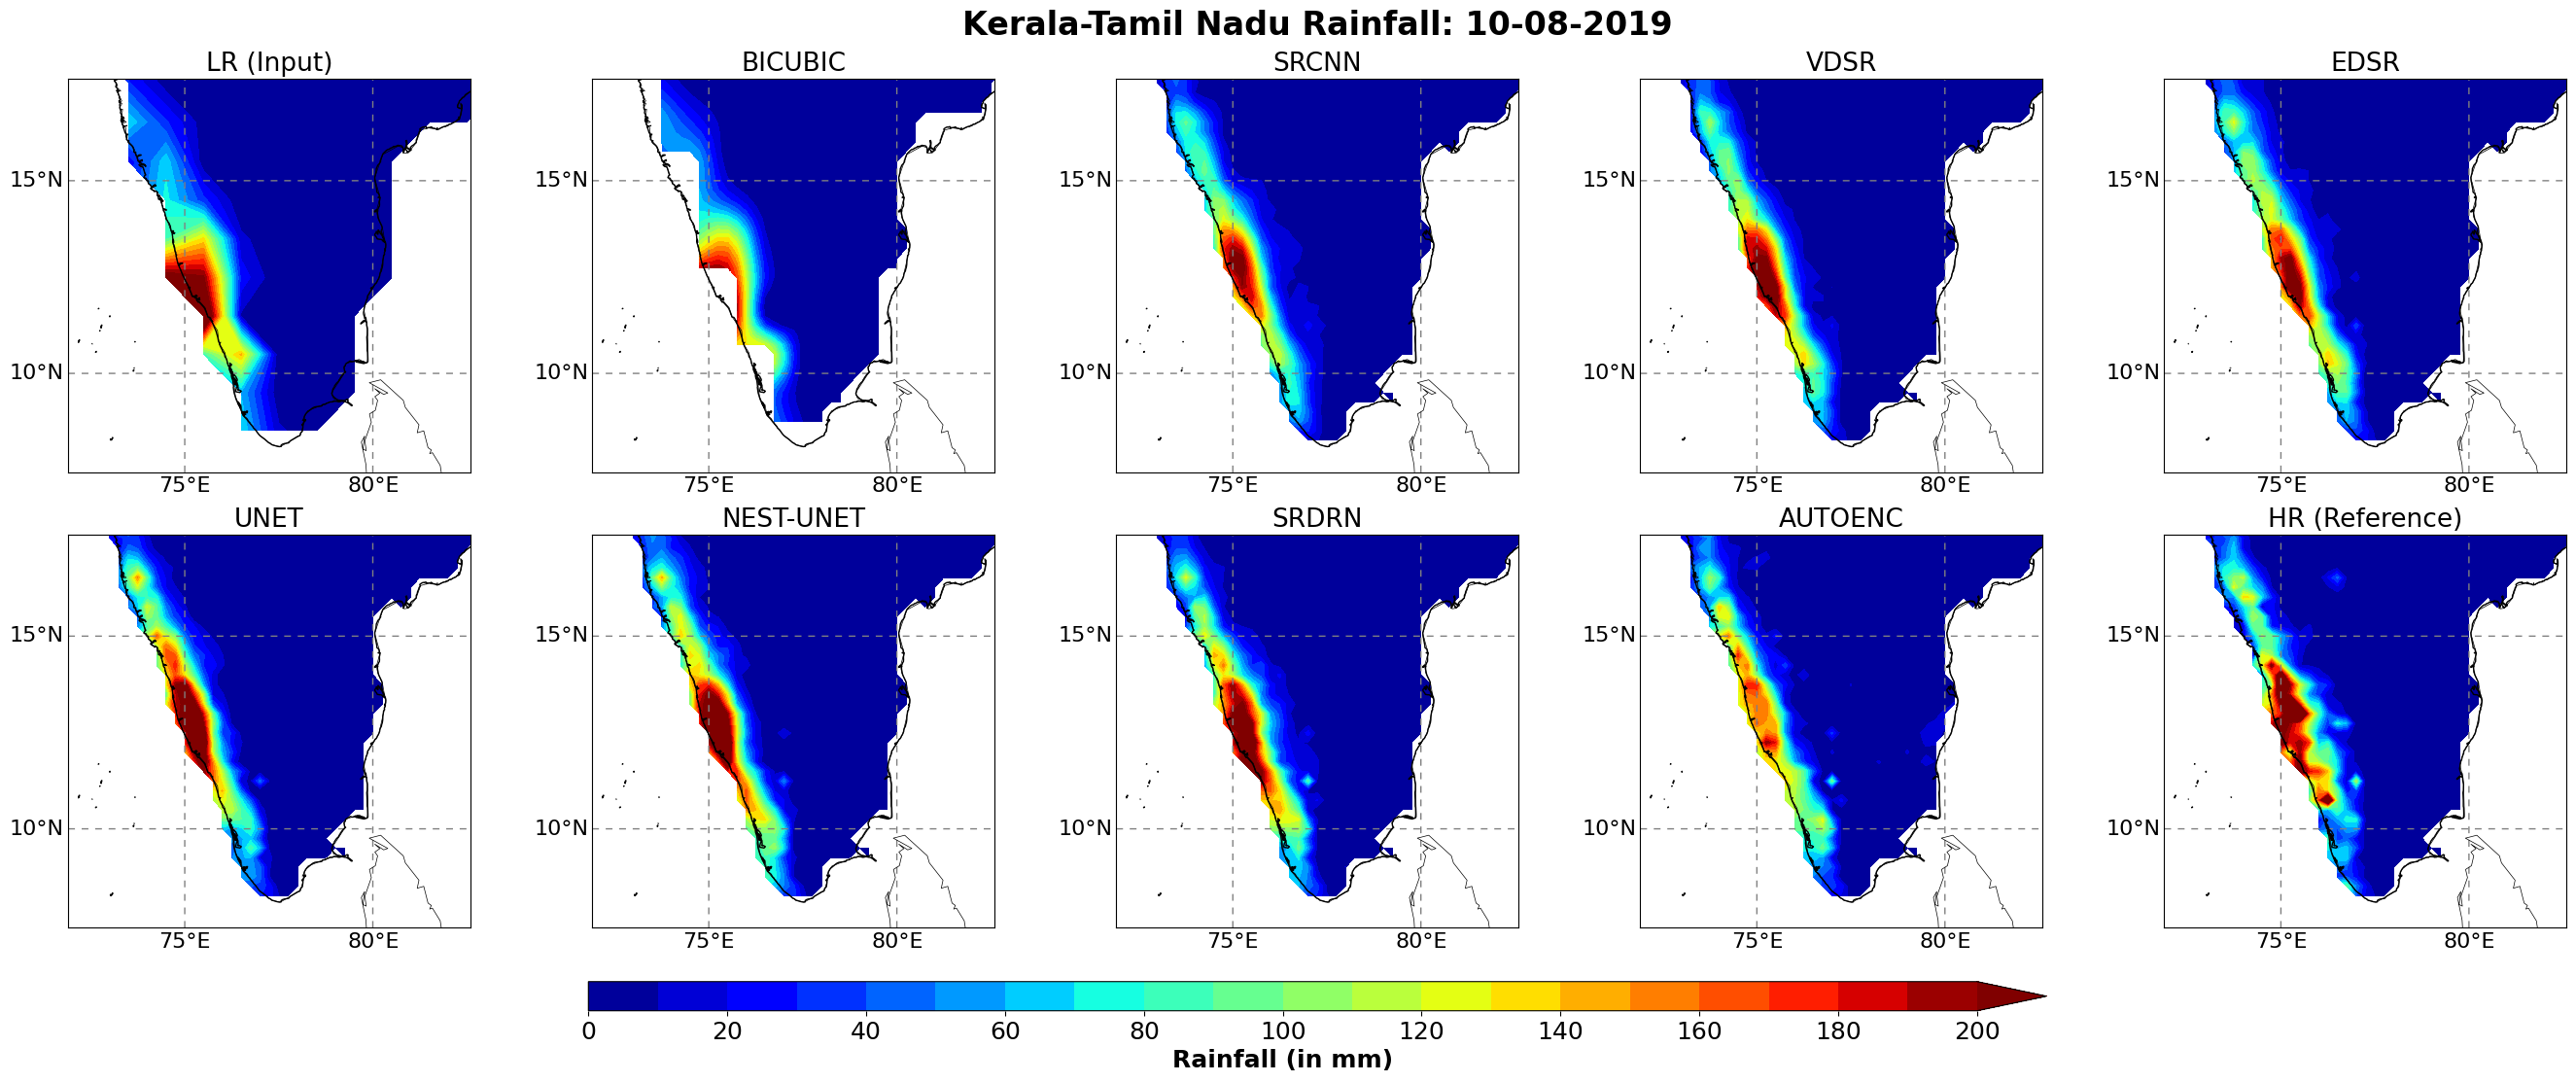

In [25]:
# Figure S2 c)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=7.4,urcrnrlat=17.6,llcrnrlon=71.9,urcrnrlon=82.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 1317
fig= plt.figure(figsize=(30,10), facecolor = 'white')

fig.suptitle('Kerala-Tamil Nadu Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=19)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=19)
  else:
    ax.set_title('NEST-UNET', fontsize=19)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=19)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 16, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S2c.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-26-0a7504a17fb7>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


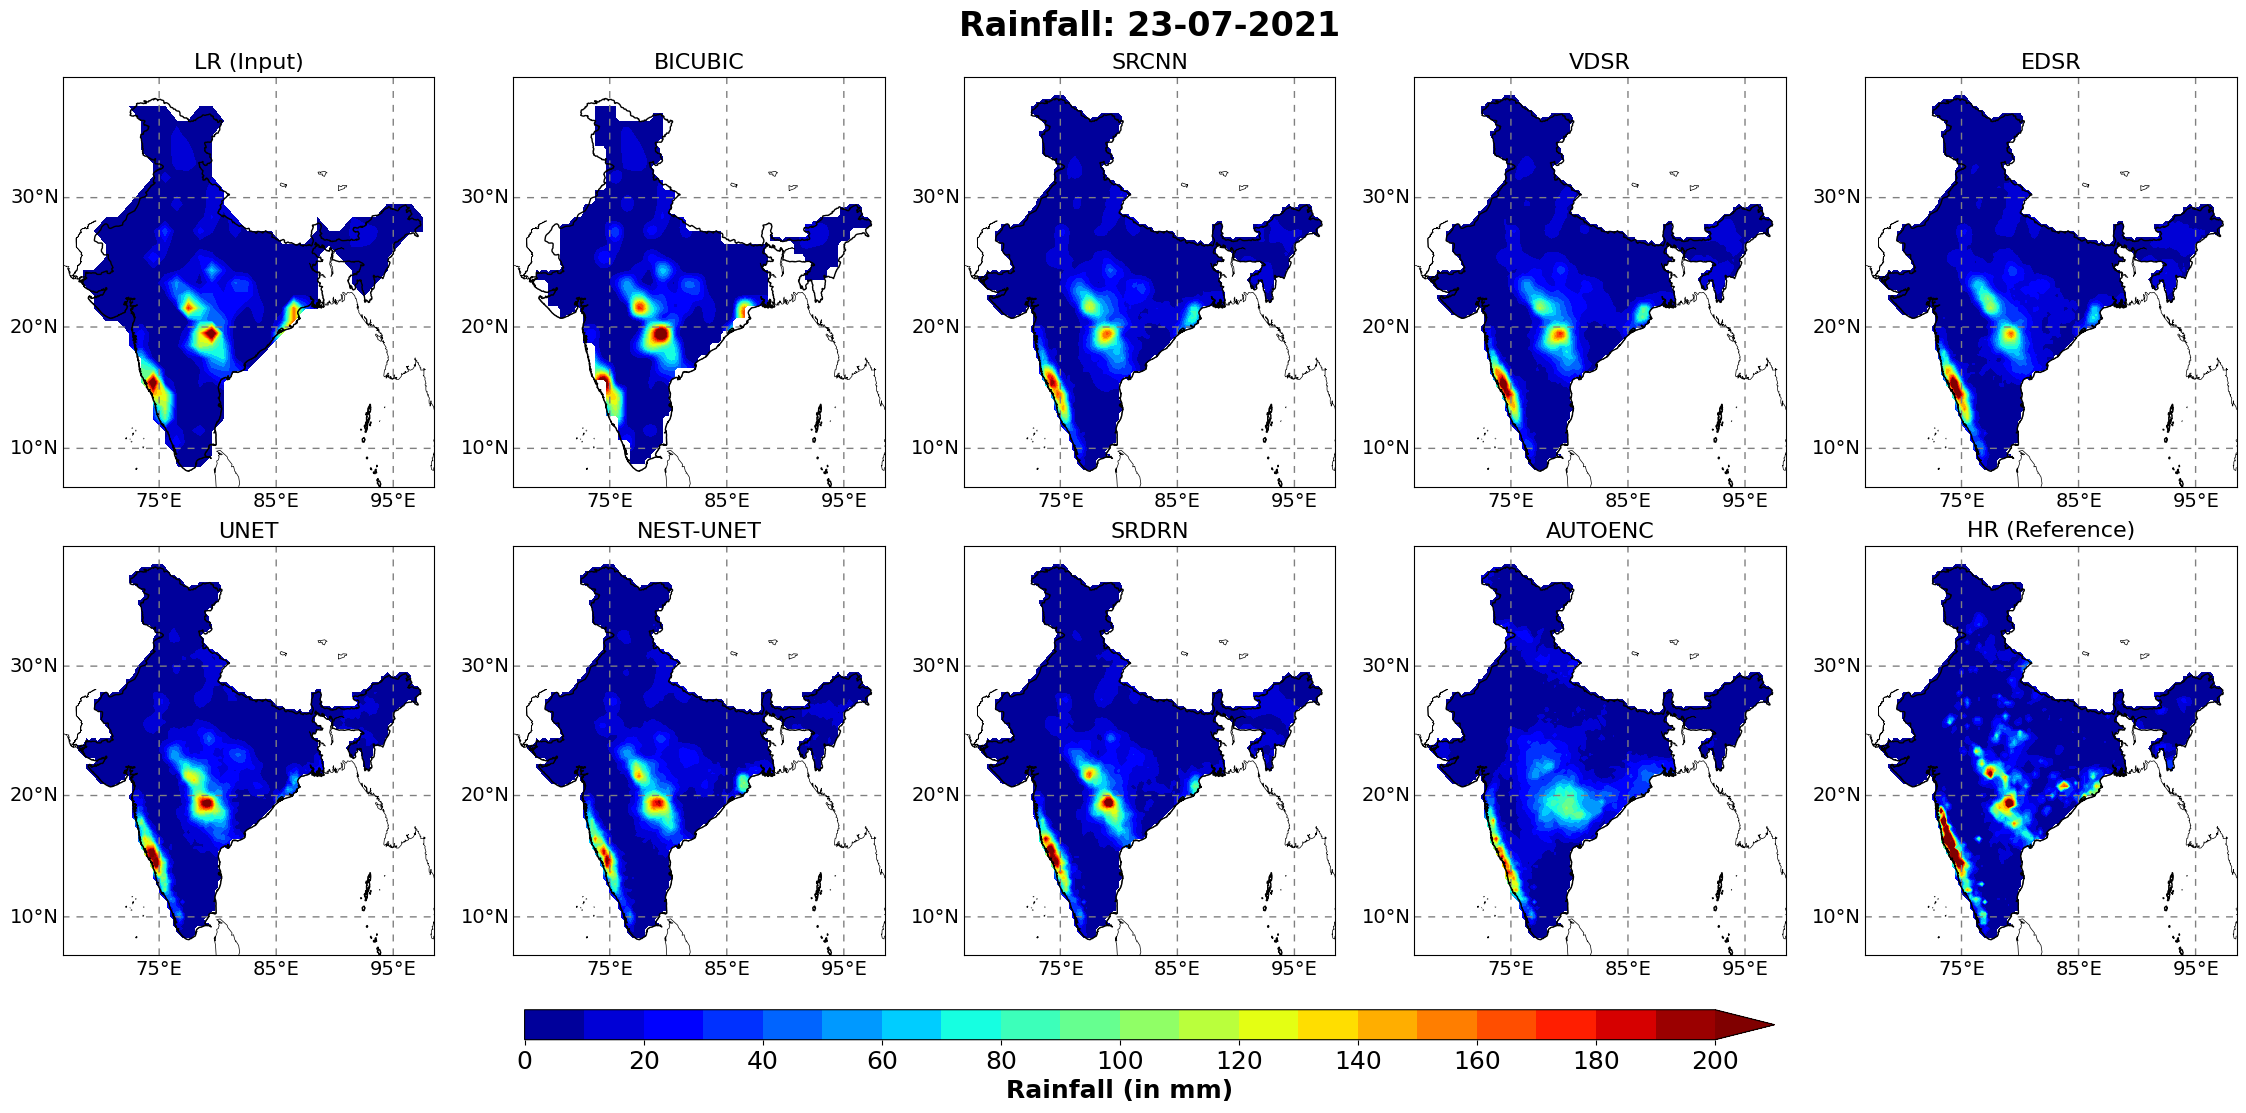

In [26]:
# Plotting Supplementary Figures
# Figure S3 a)
bm=Basemap(projection='merc',llcrnrlat=6.75,urcrnrlat=38.5,llcrnrlon=66.75,urcrnrlon=98.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(25,10), facecolor = 'white')

fig.suptitle('Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
            fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
    ax = fig.add_subplot(2,5,subplot)
    if x != 'NEST_UNET':
      ax.set_title(x, fontsize=16)
    else:
      ax.set_title('NEST-UNET', fontsize=16)
    bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
    bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
    bm.drawcoastlines(linewidth=0.5)
    bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
    subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,10), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S3a.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-27-2dae15126a76>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


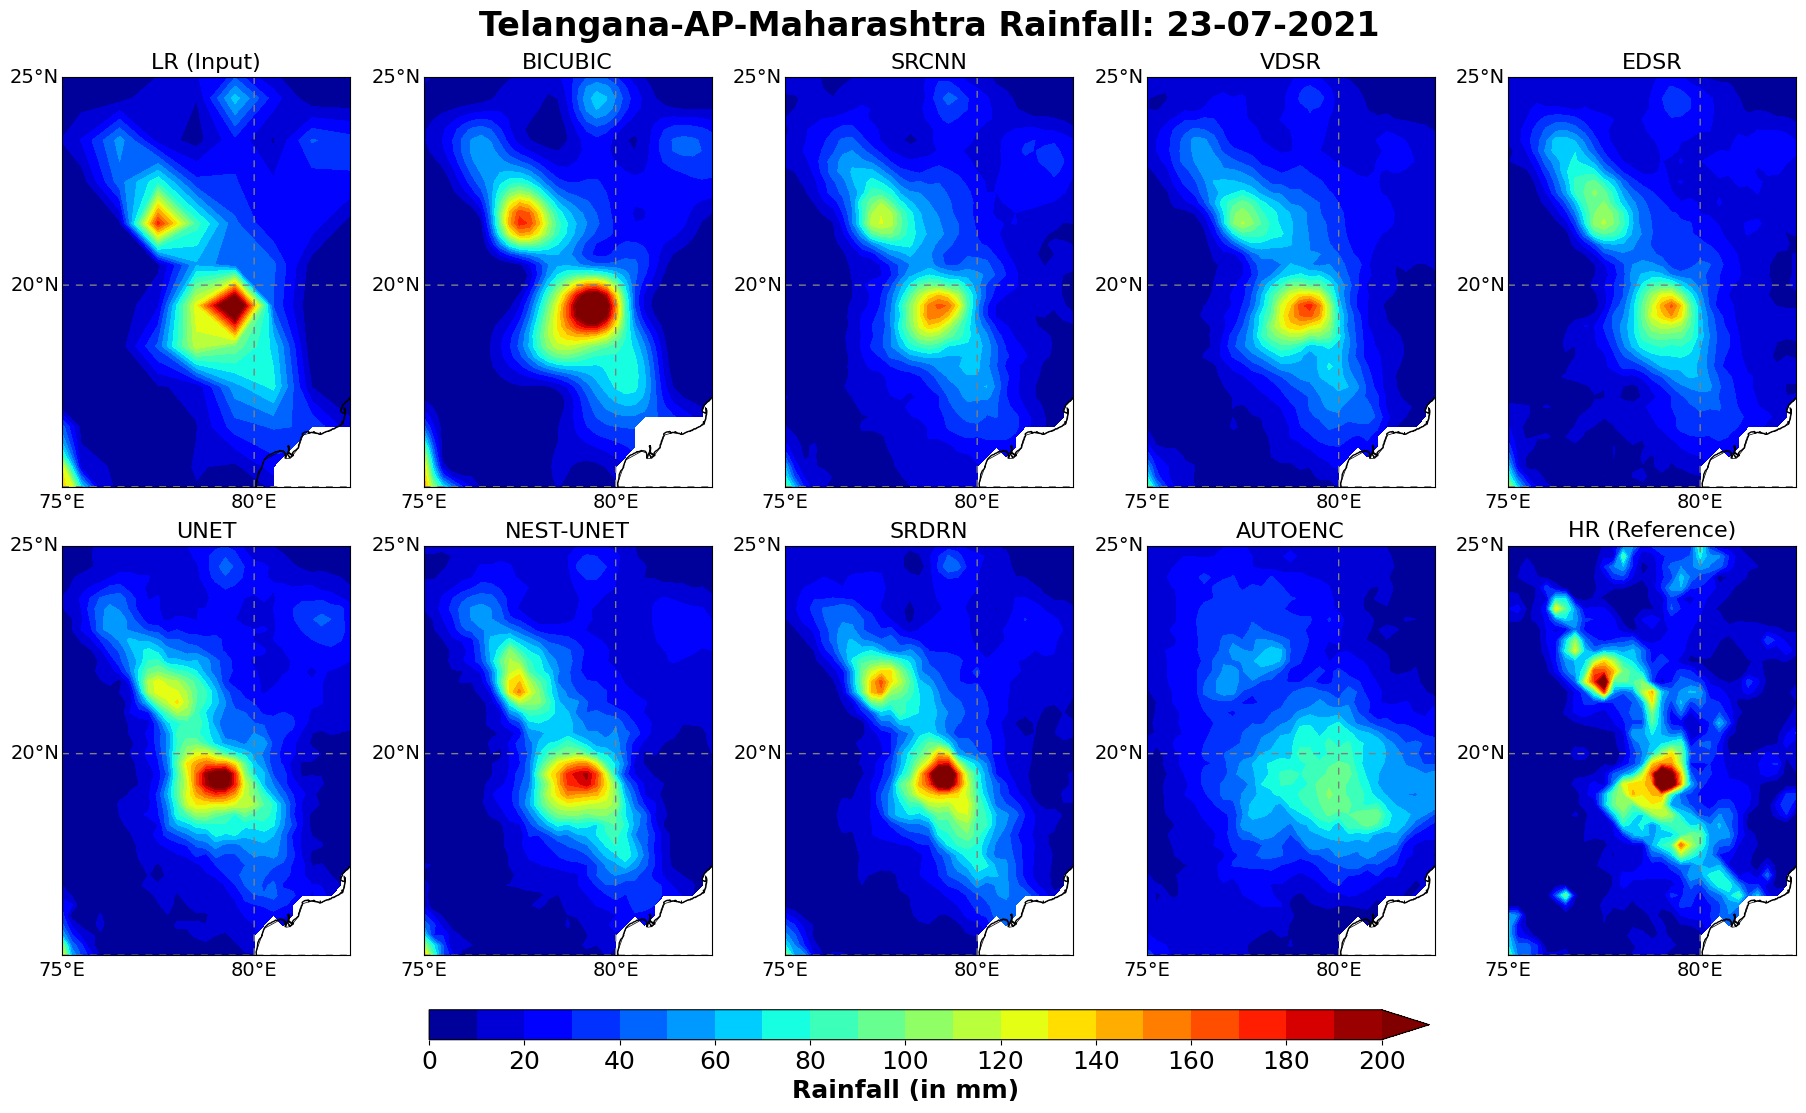

In [27]:
# Figure S3 b)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=15,urcrnrlat=25,llcrnrlon=75,urcrnrlon=82.5, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(20,10), facecolor = 'white')

fig.suptitle('Telangana-AP-Maharashtra Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=16)
  else:
    ax.set_title('NEST-UNET', fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S3b.png', bbox_inches = 'tight', dpi = 300)

<ipython-input-28-f3068d835666>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


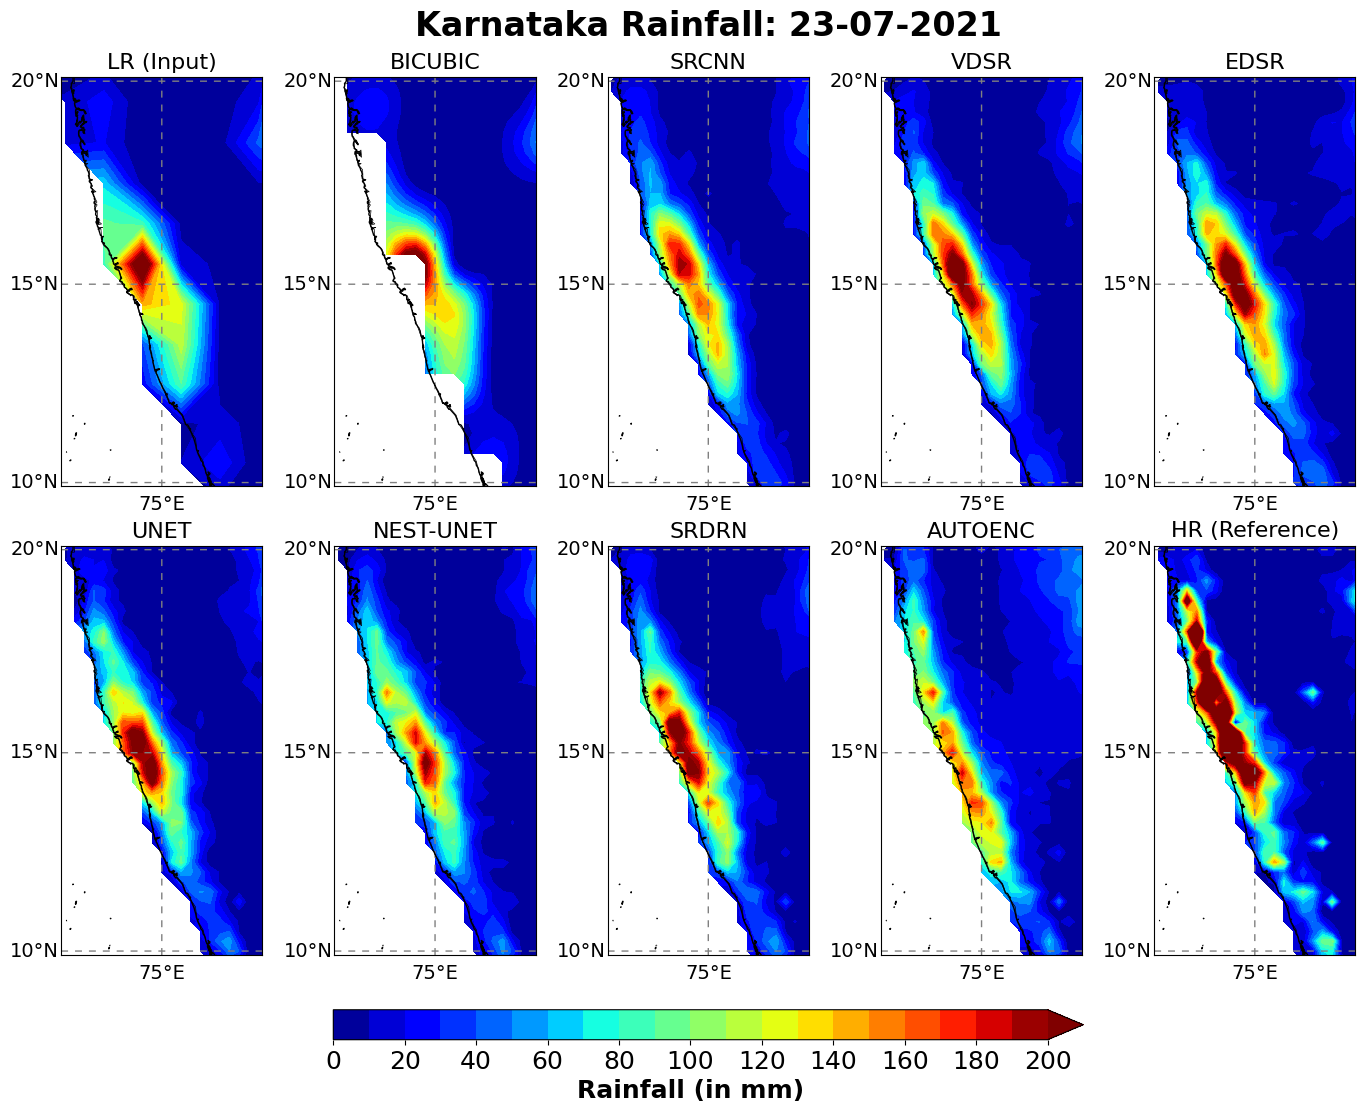

In [28]:
# Figure S3 c)
# Regional picture.
bm=Basemap(projection='merc',llcrnrlat=9.9,urcrnrlat=20.1,llcrnrlon=72.4,urcrnrlon=77.6, resolution='l')
contour_levels = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

lons_025, lats_025 = np.meshgrid(other['lon_025'], other['lat_025'])
lons_100, lats_100 = np.meshgrid(other['lon_100'], other['lat_100'])
xi_025, yi_025 = bm(lons_025, lats_025)
xi_100, yi_100 = bm(lons_100, lats_100)

d = 2030
fig= plt.figure(figsize=(15,10), facecolor = 'white')

fig.suptitle('Karnataka Rainfall: '+str(other['dates'][d])[8:10]+'-'+str(other['dates'][d])[5:7]+'-'+str(other['dates'][d])[0:4], \
             fontsize = 24, fontweight = 'bold')

ax = fig.add_subplot(2,5,1)
ax.set_title('LR (Input)', fontsize=16)
bm.contourf(xi_100,yi_100,np.squeeze(inputs[d]*mask_100), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,True,False], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

subplot = 2
for x in ['BICUBIC', 'SRCNN', 'VDSR', 'EDSR', 'UNET', 'NEST_UNET', 'SRDRN', 'AUTOENC']:
  ax = fig.add_subplot(2,5,subplot)
  if x != 'NEST_UNET':
    ax.set_title(x, fontsize=16)
  else:
    ax.set_title('NEST-UNET', fontsize=16)
  bm.contourf(xi_025,yi_025,np.squeeze(outputs[x]*mask_025)[d], contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
  bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
  bm.drawcoastlines(linewidth=0.5)
  bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)
  subplot = subplot + 1

ax = fig.add_subplot(2,5,10)
ax.set_title('HR (Reference)', fontsize=16)
colormap = bm.contourf(xi_025,yi_025,np.squeeze(groundtruths[d]*mask_025), contour_levels, cmap='jet', extend = 'max', norm = mpl.colors.Normalize(vmin=0, vmax=200))
bm.drawparallels(np.arange(0,40,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawmeridians(np.arange(65,100,5), labels=[True,False,False,True], fontsize = 14, dashes = (5, 5), color = 'grey')
bm.drawcoastlines(linewidth=0.5)
bm.readshapefile('../DATA/INDIA_SHAPEFILE/INDIA_SHAPEFILE', 'INDIA_SHAPEFILE', linewidth = 1)

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.03])
cbar = fig.colorbar(colormap, cax=cbar_ax, orientation = 'horizontal', ticks = [0,20,40,60,80,100,120,140,160,180,200])
cbar.ax.tick_params(axis = 'both', labelsize=18)
cbar.set_label(label='Rainfall (in mm)', weight='bold', size = 18)
fig.tight_layout()
plt.savefig('./plots/Fig_S3c.png', bbox_inches = 'tight', dpi = 300)



---


In [29]:
!pip freeze > environment.txt